In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re

import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import cv2
import random
import sc_toolbox
import gseapy as gp

from glob import glob
from scipy.sparse import csr_matrix, isspmatrix
from datetime import datetime
from collections import defaultdict

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

In [3]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import utils as us
from src.utils import functional_utils as fu
from src.utils import visualise as vs
%load_ext autoreload
%autoreload 2

In [4]:
sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
%%R
library(edgeR)
library(limma)
# library(MAST)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


Loading required package: limma
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


# Load Data

In [6]:
def index(data, name='Unnamed: 0'):
    data.index = pd.Index(data[name])
    data.drop([name], axis=1, inplace=True)
    return data

In [7]:
paths = glob(str(config.PATHS.LOGS/'w*_markers.csv'))
timeline = dict()

for path in paths:
    selected = index(pd.read_csv(path), 'names')
    selected.drop(['Unnamed: 0'], axis=1, inplace=True)
    week = int(re.findall(r'w([0-9]+).*', os.path.basename(path))[0])
    timeline[week] = selected

In [8]:
reactome = fu.load_GO()
collectri = fu.load_collectri()

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialising MSigDB reactome...


In [9]:
groups = reactome.groupby('geneset').groups
sets = { k: reactome.loc[v].genesymbol for k, v in groups.items() }

# Launch

1
Launched ULM for TF slope t-stat
Launched ORA


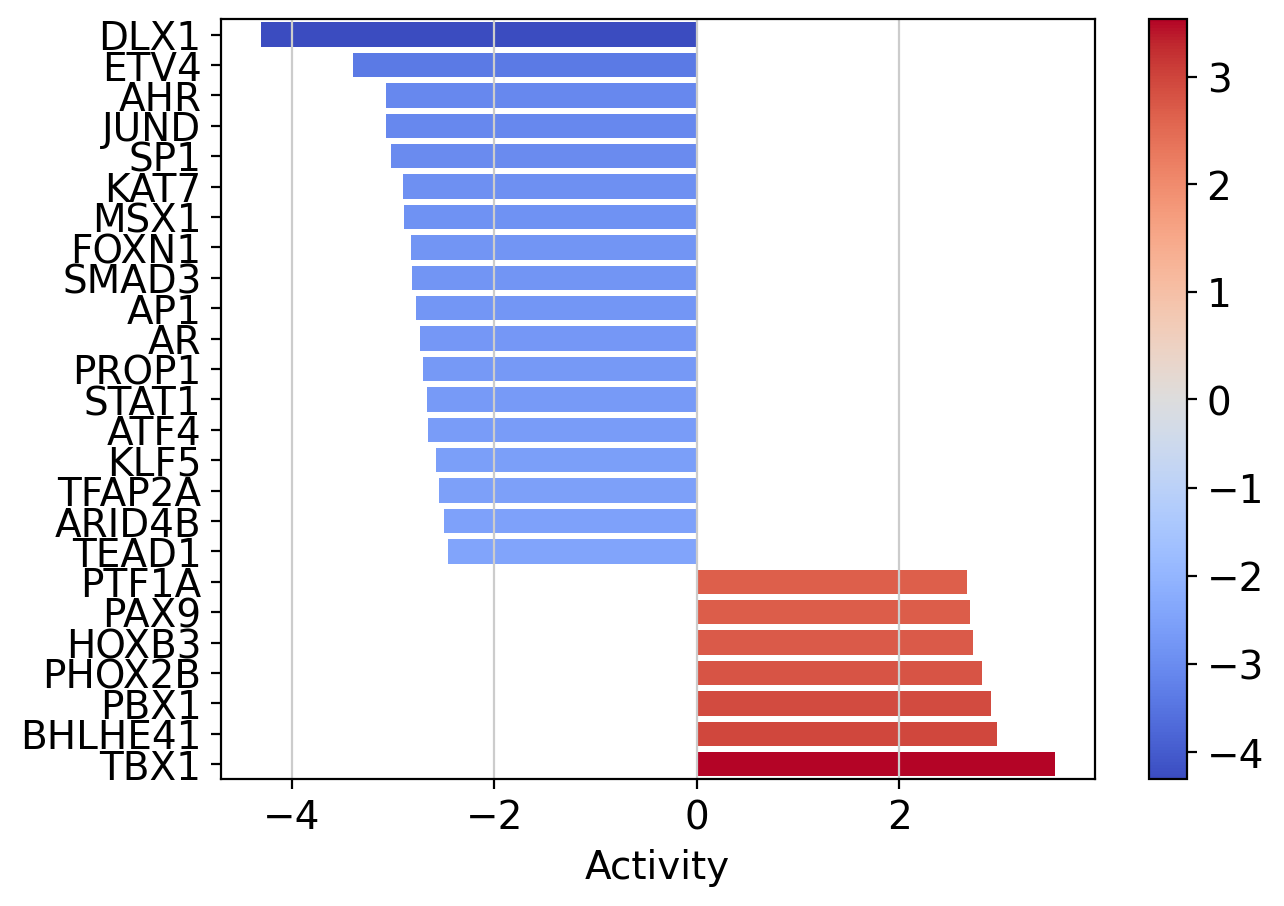

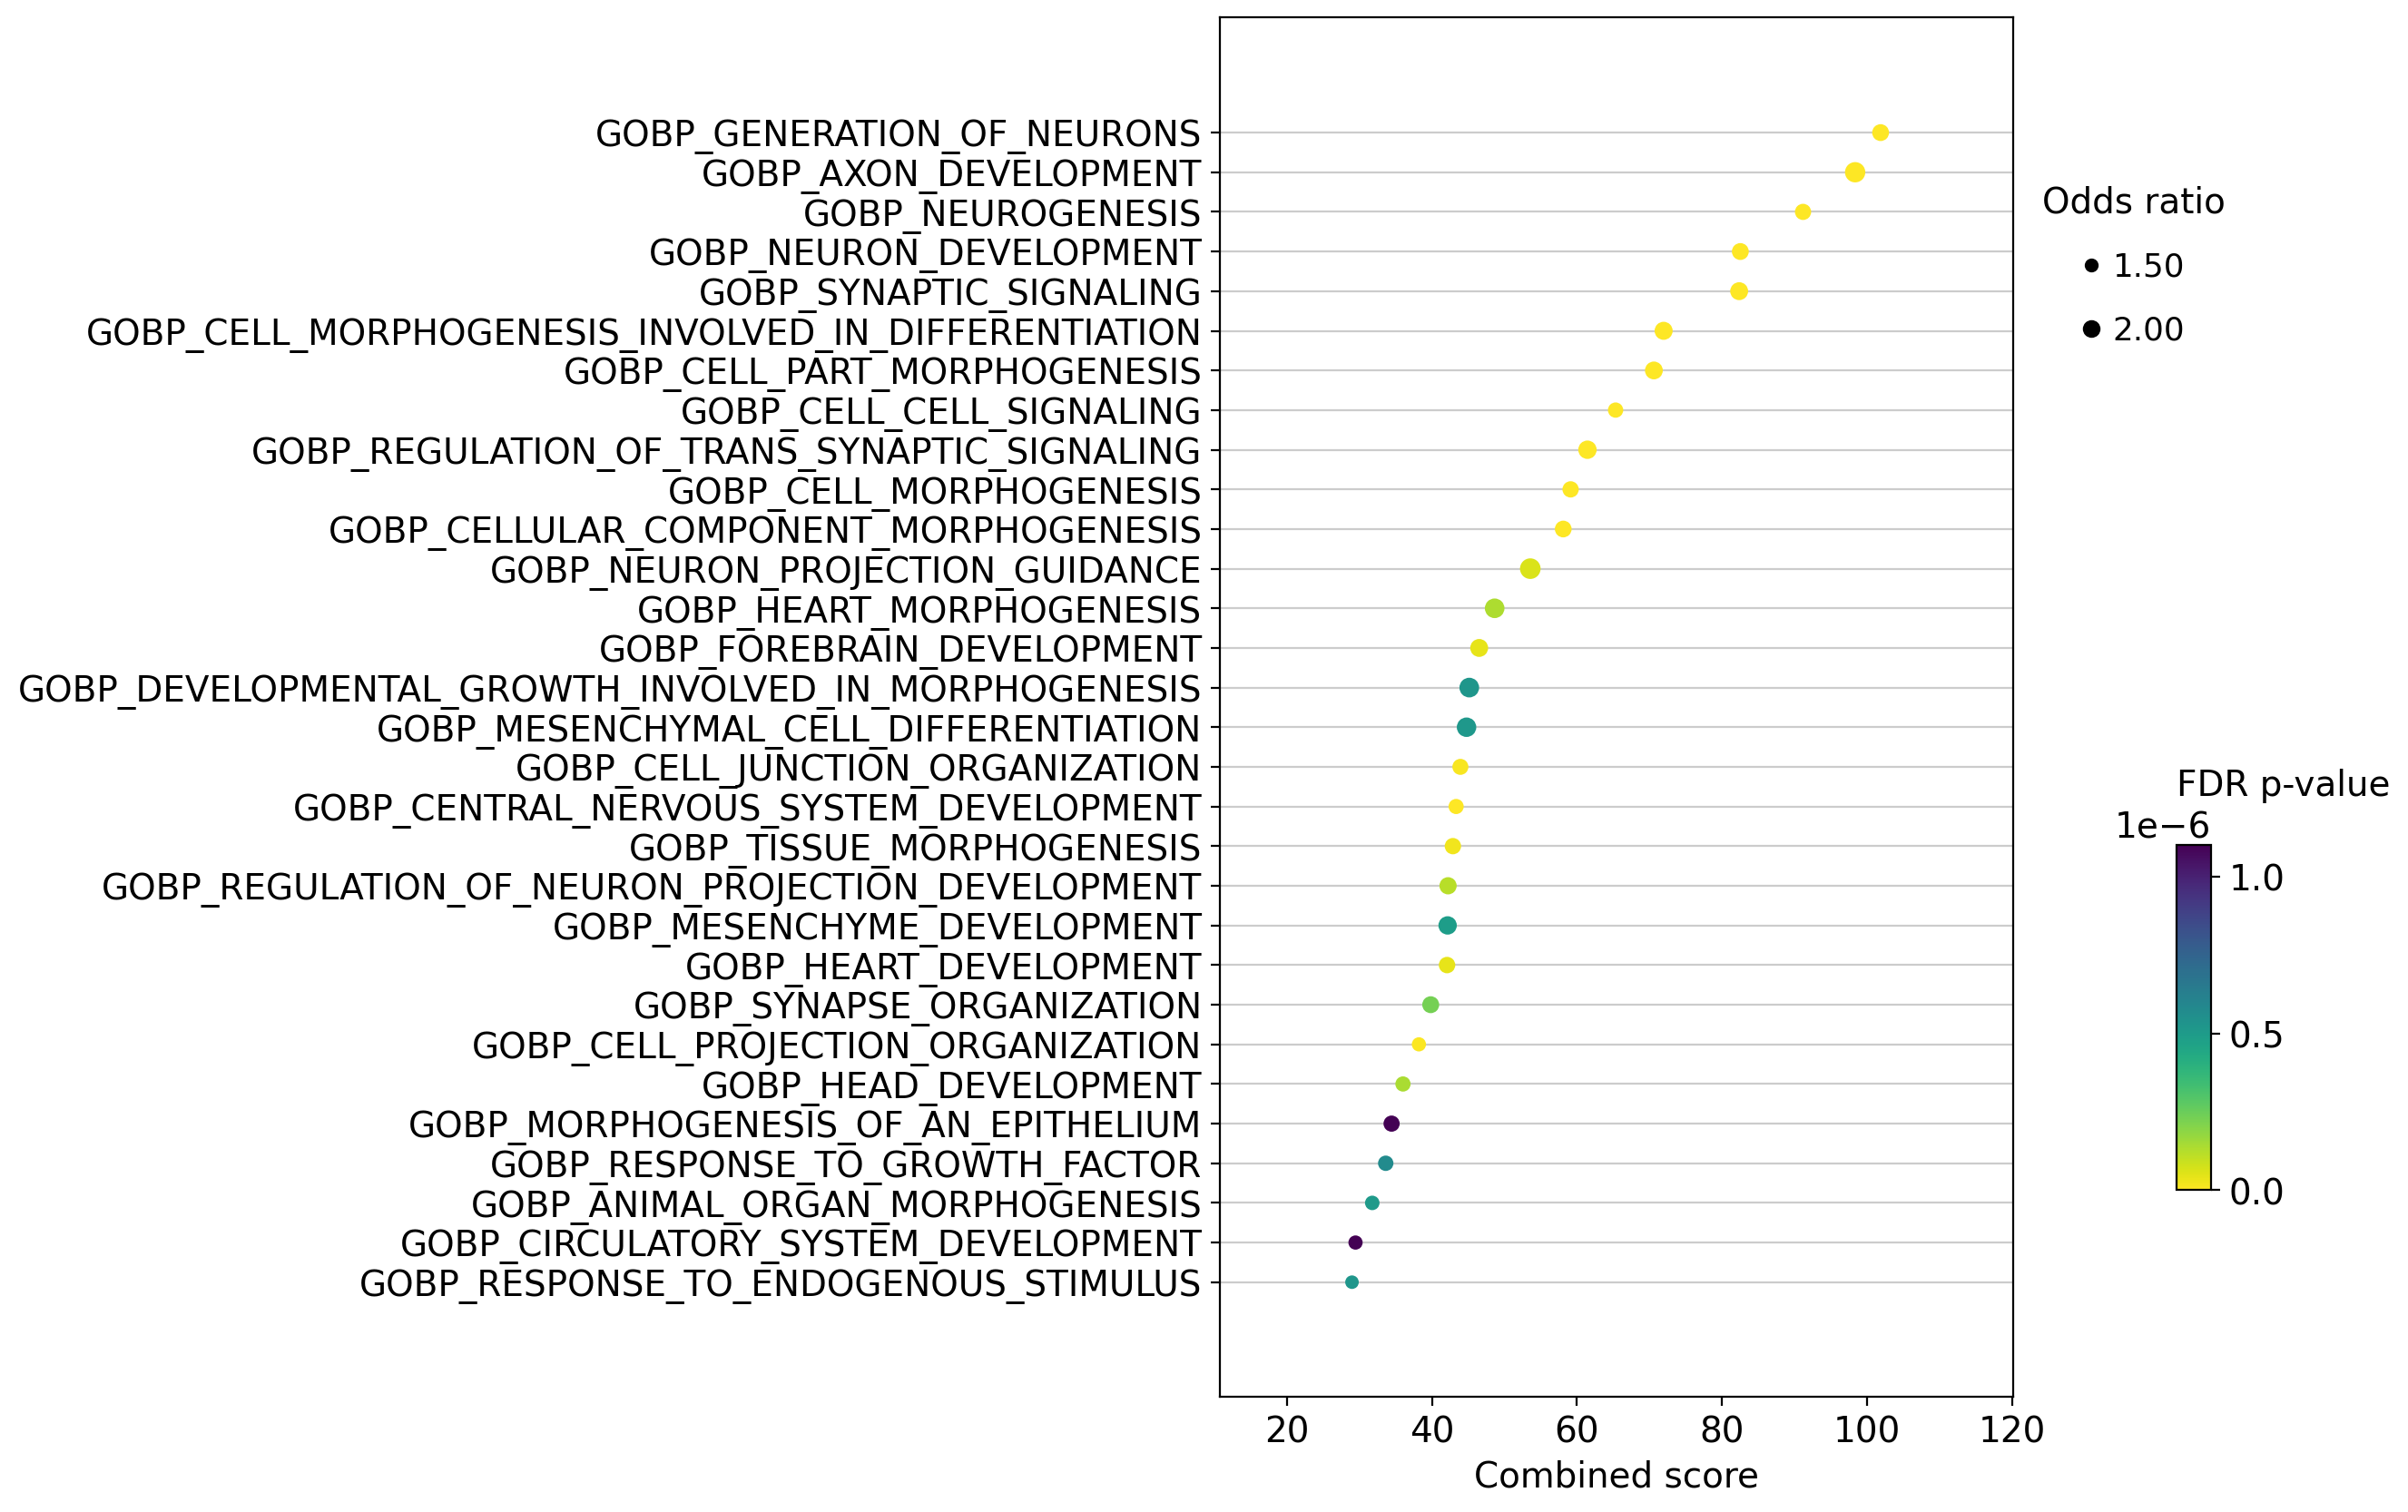

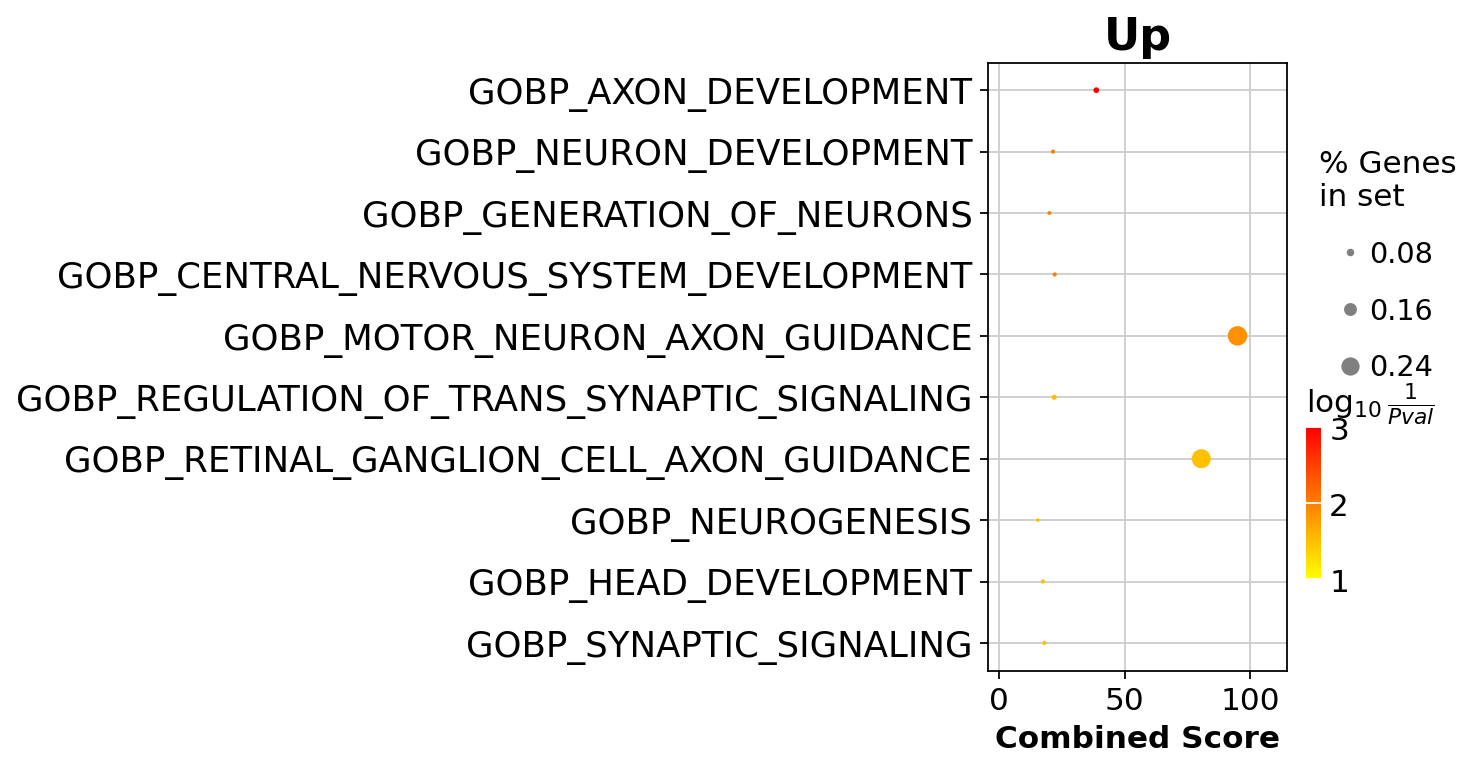

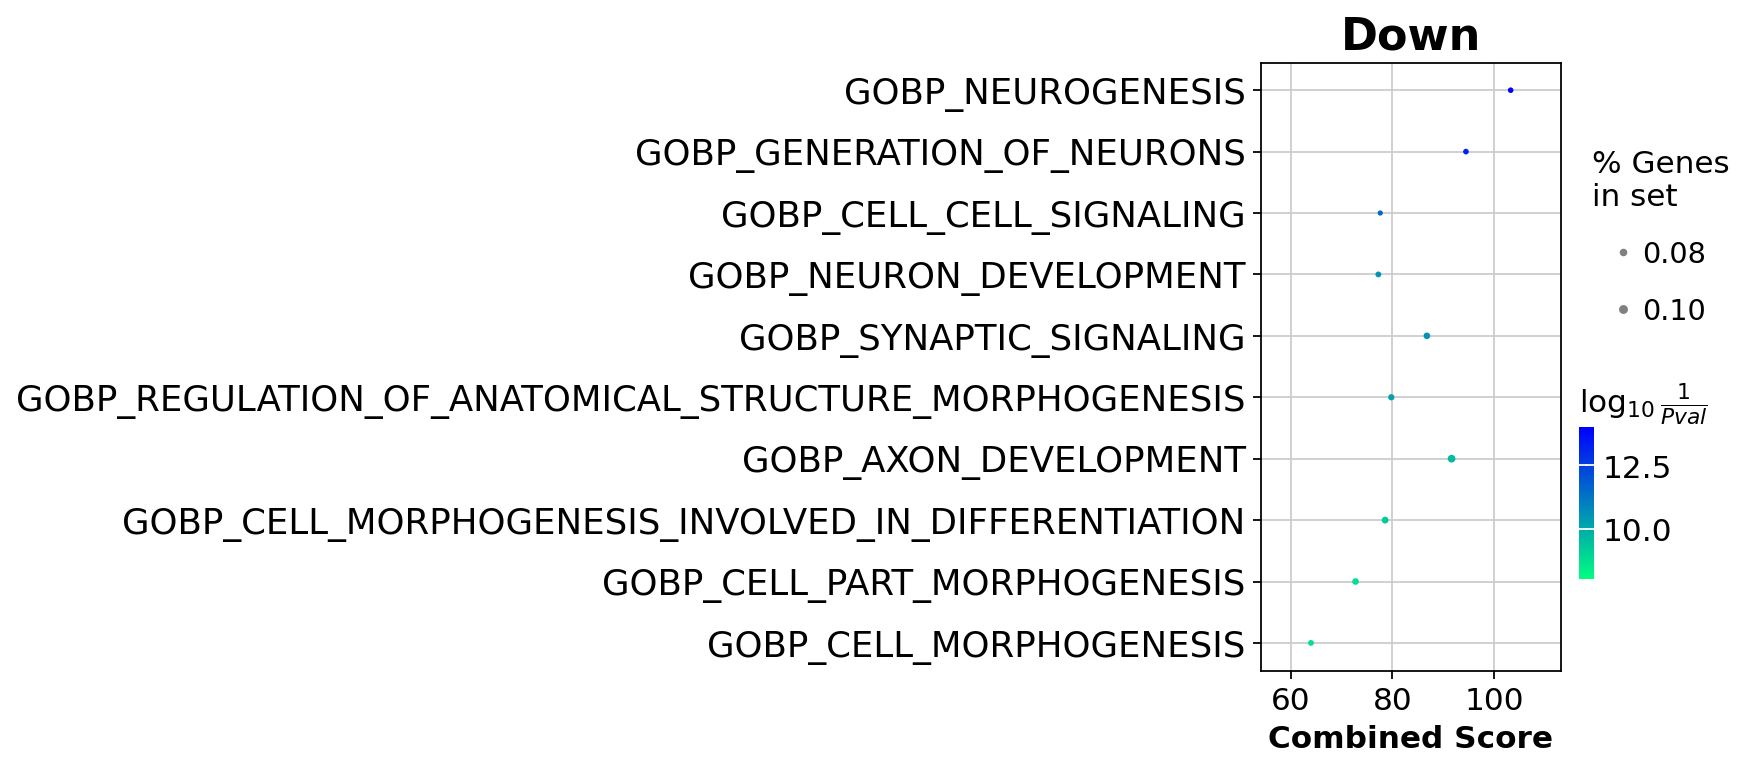

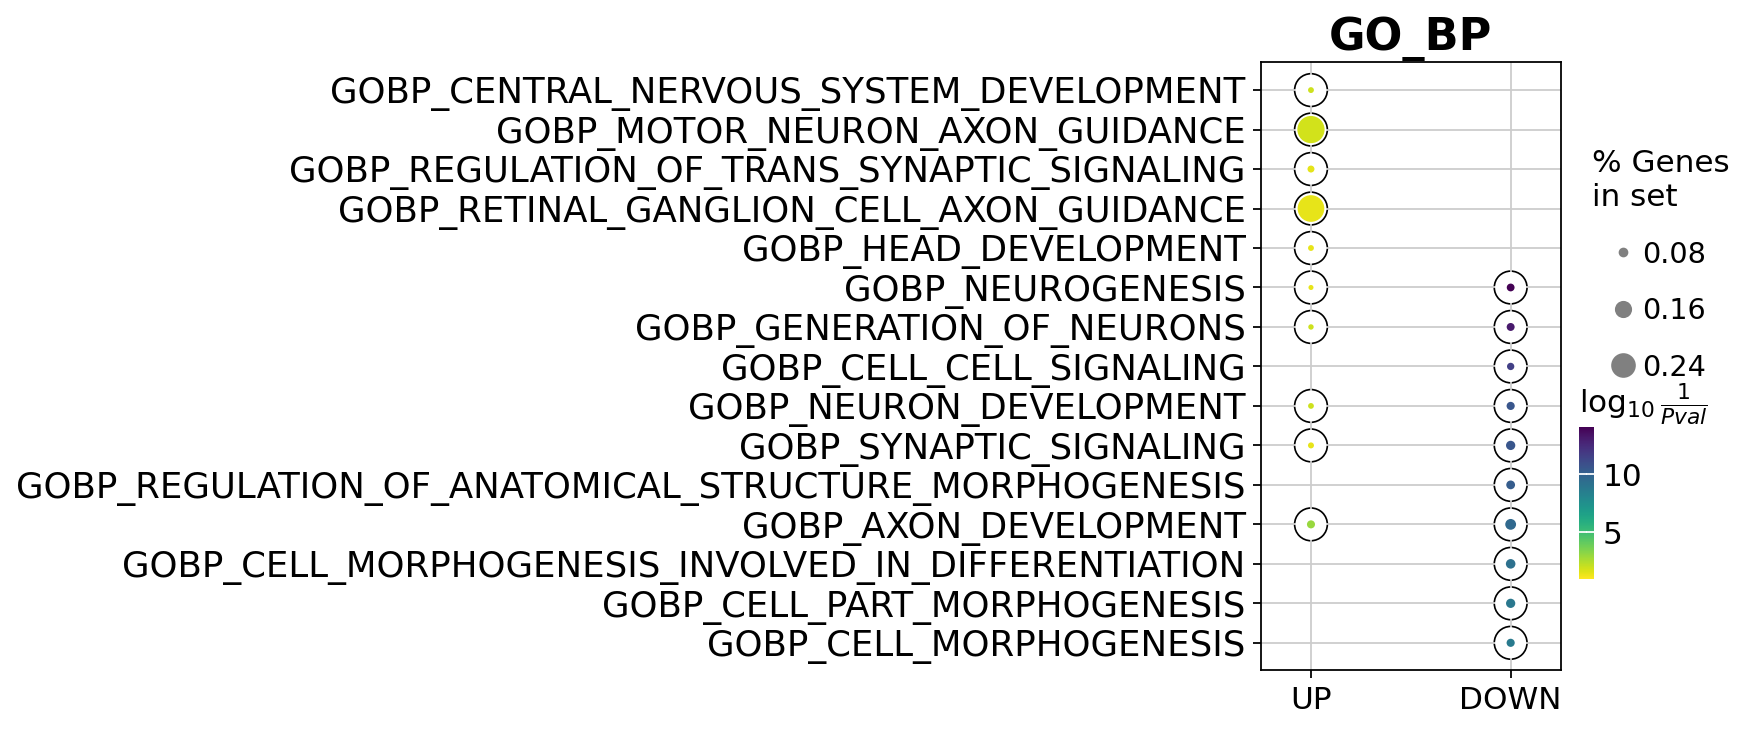

2
Launched ULM for TF slope t-stat
Launched ORA


<Figure size 320x320 with 0 Axes>

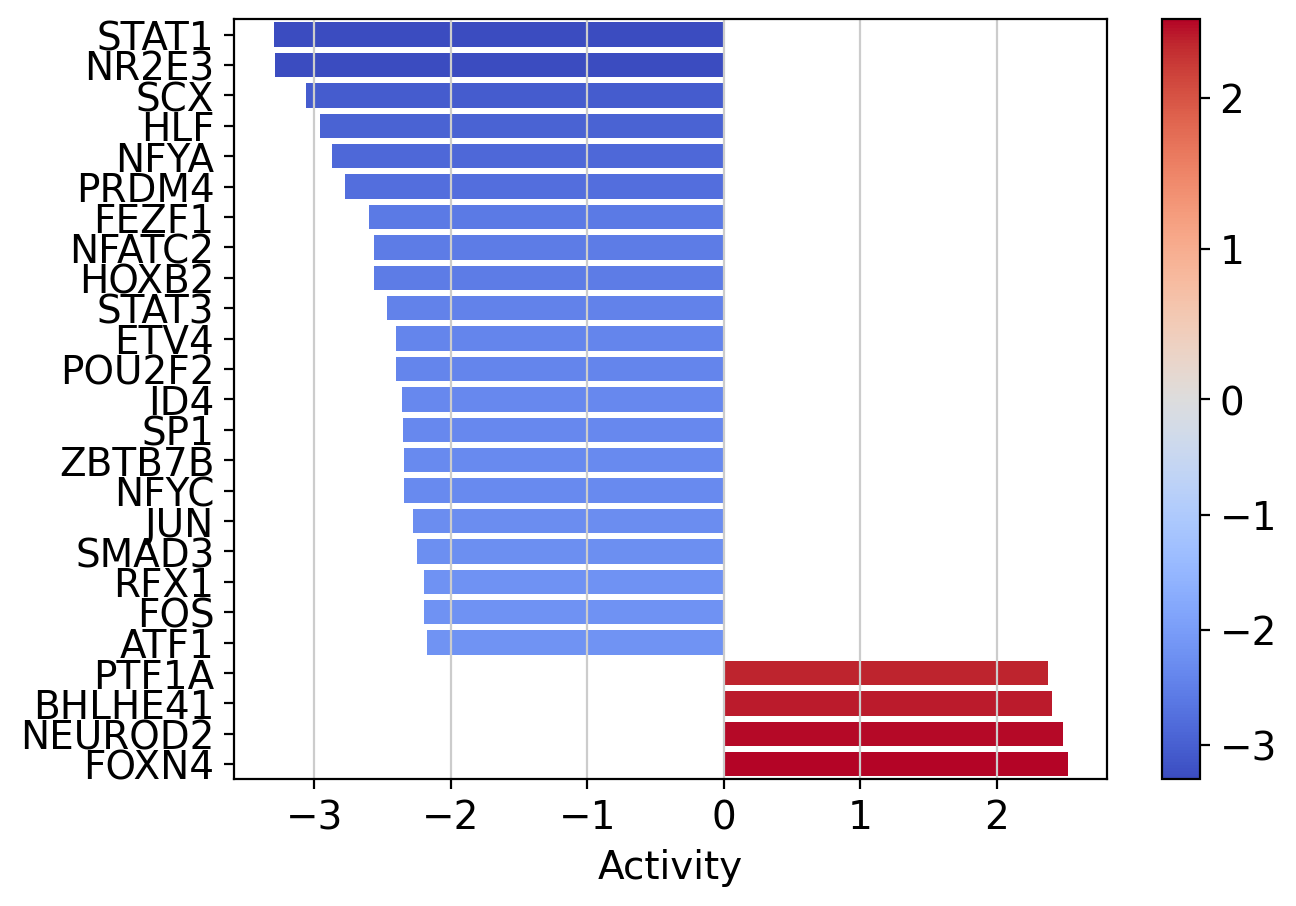

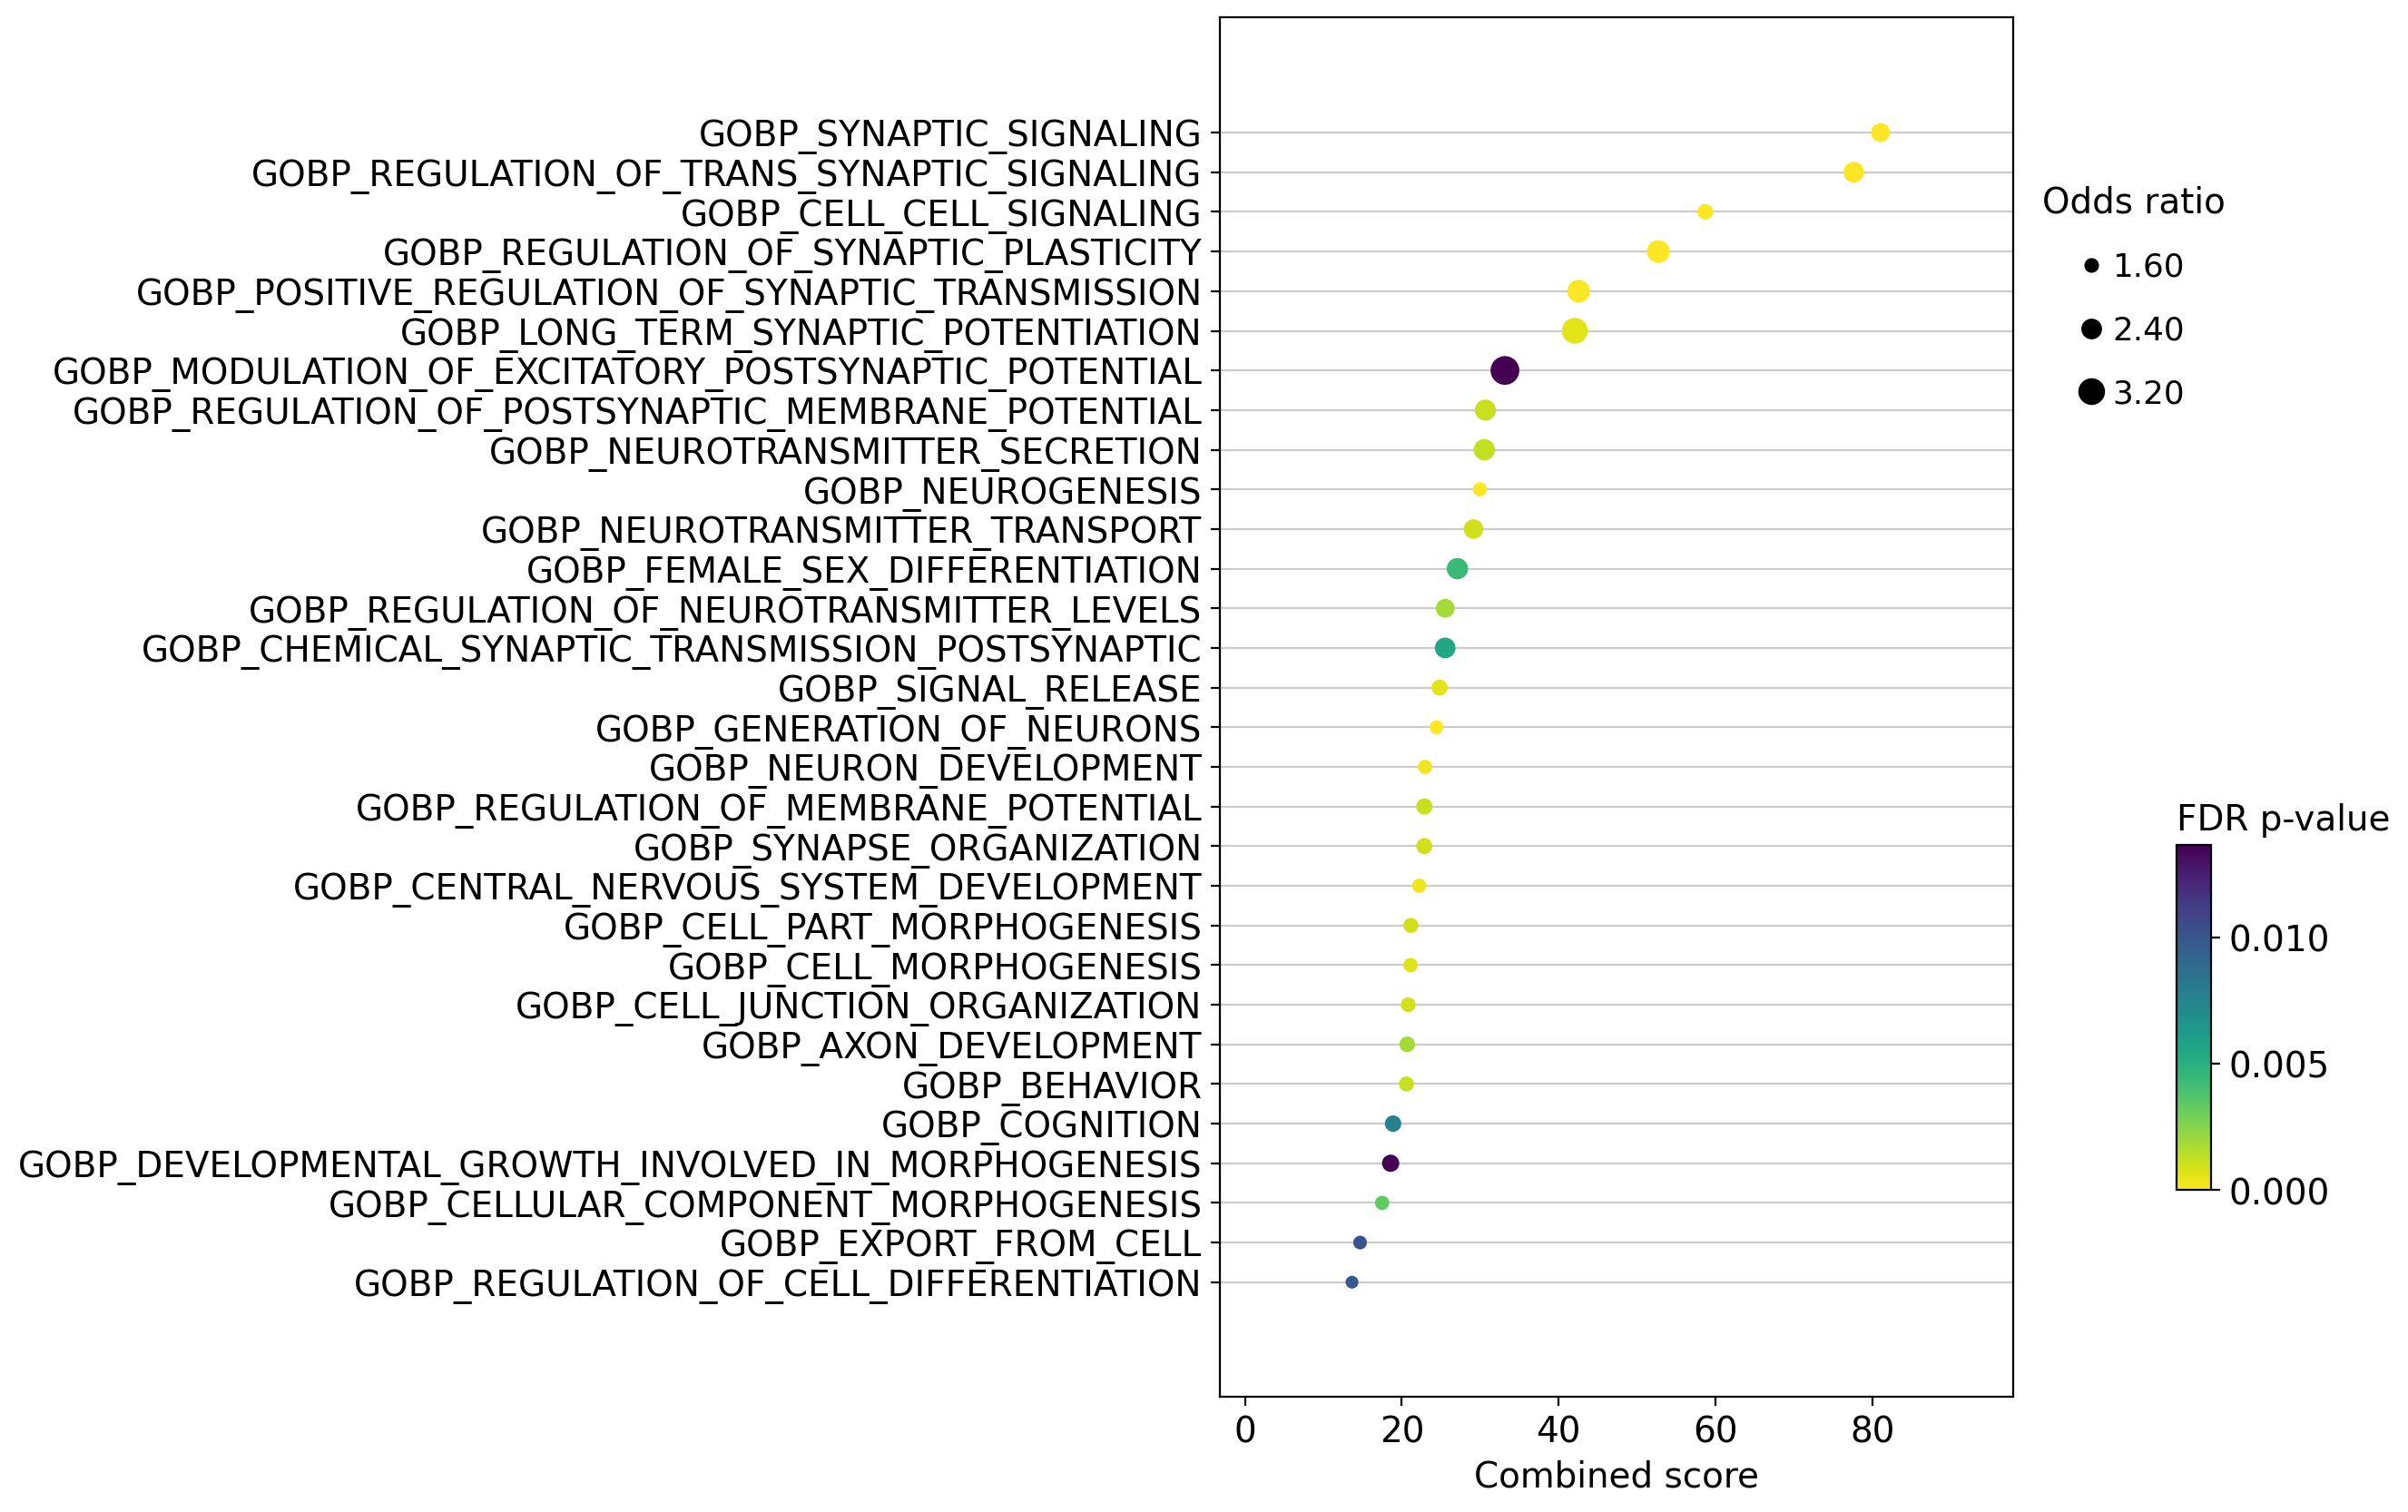

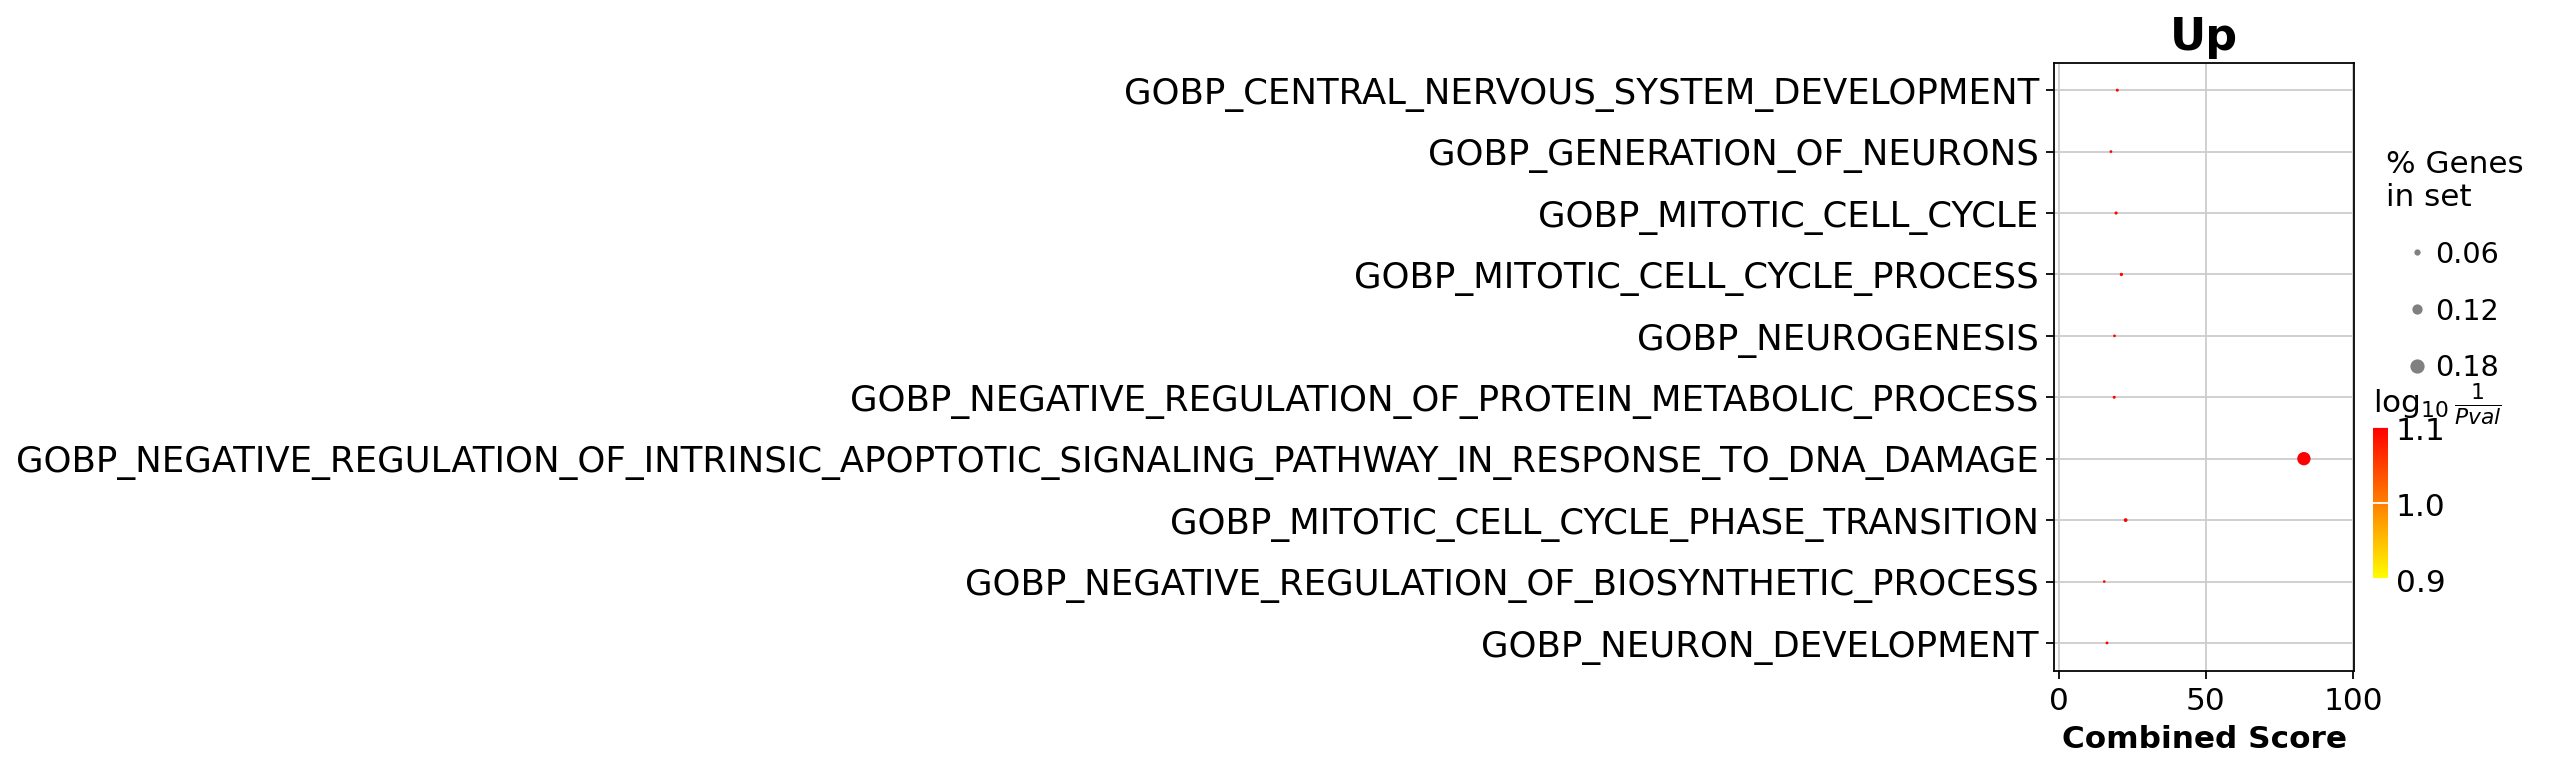

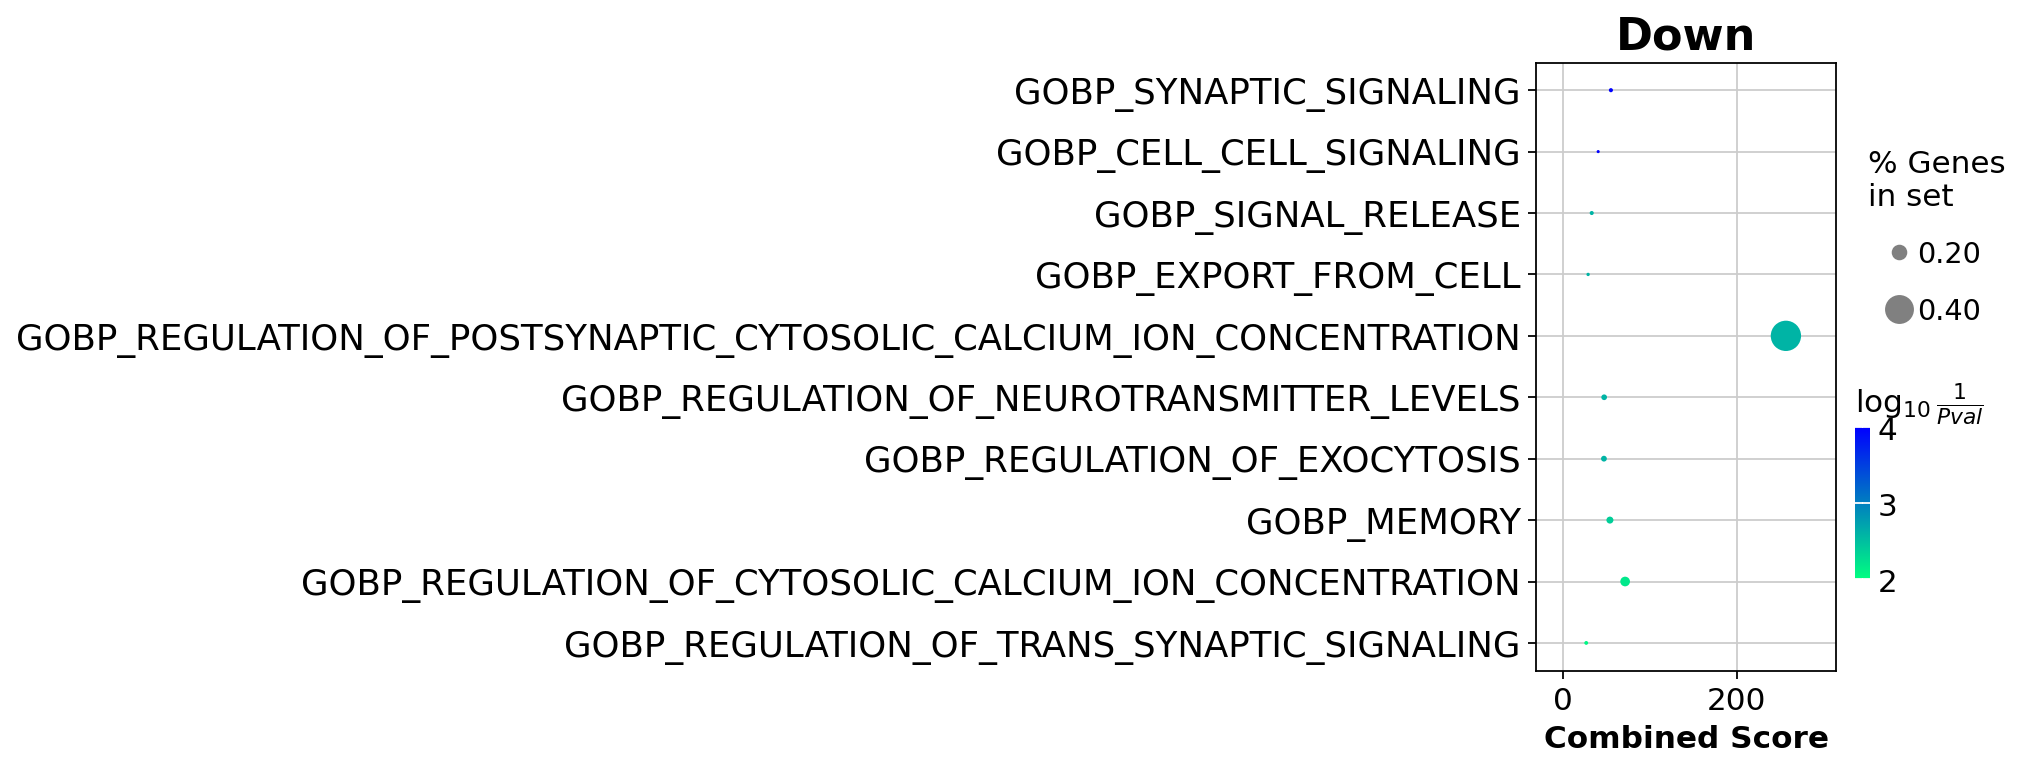

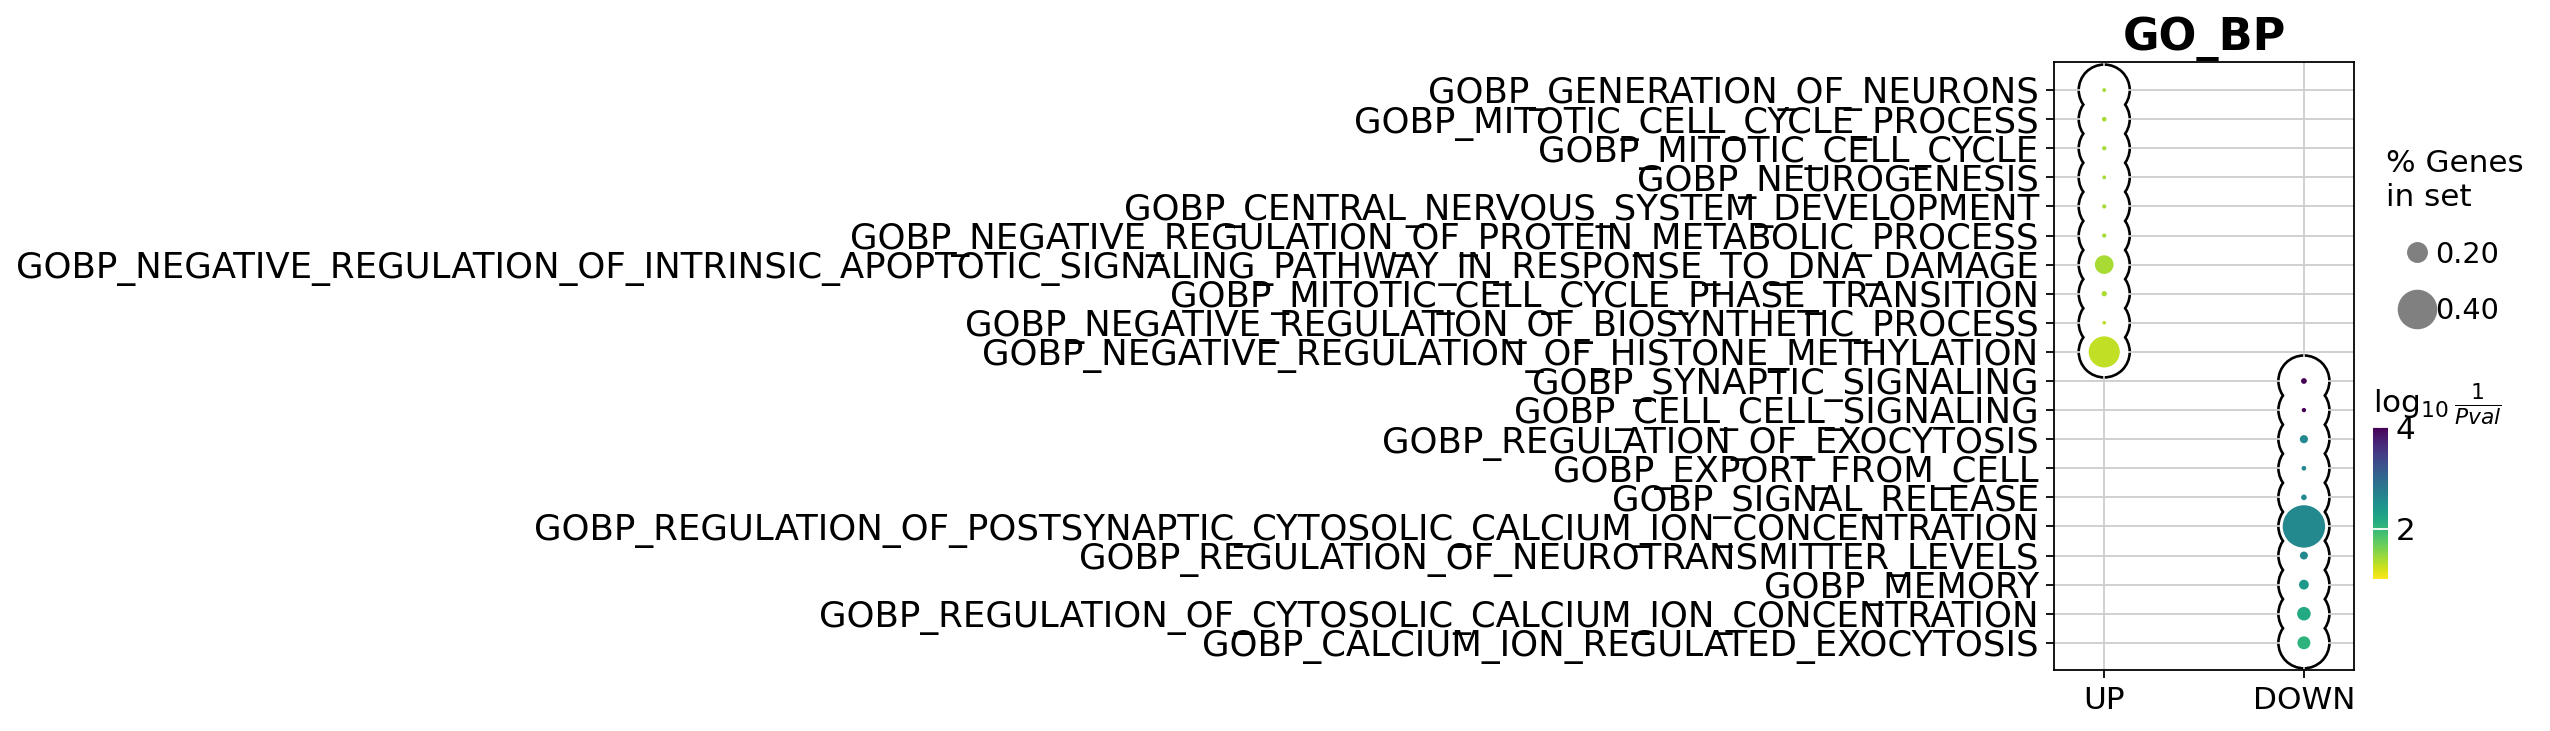

4
Launched ULM for TF slope t-stat
Launched ORA


<Figure size 320x320 with 0 Axes>

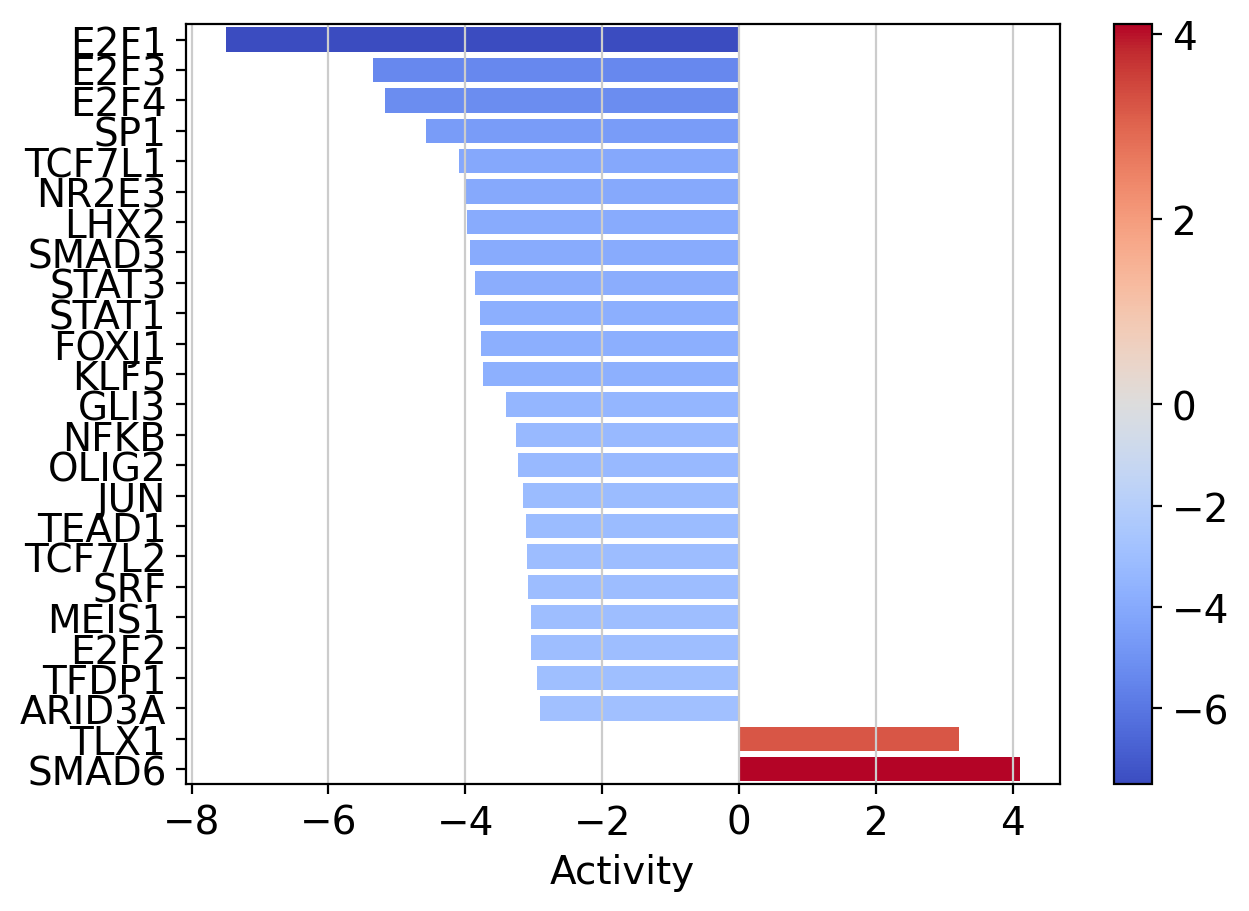

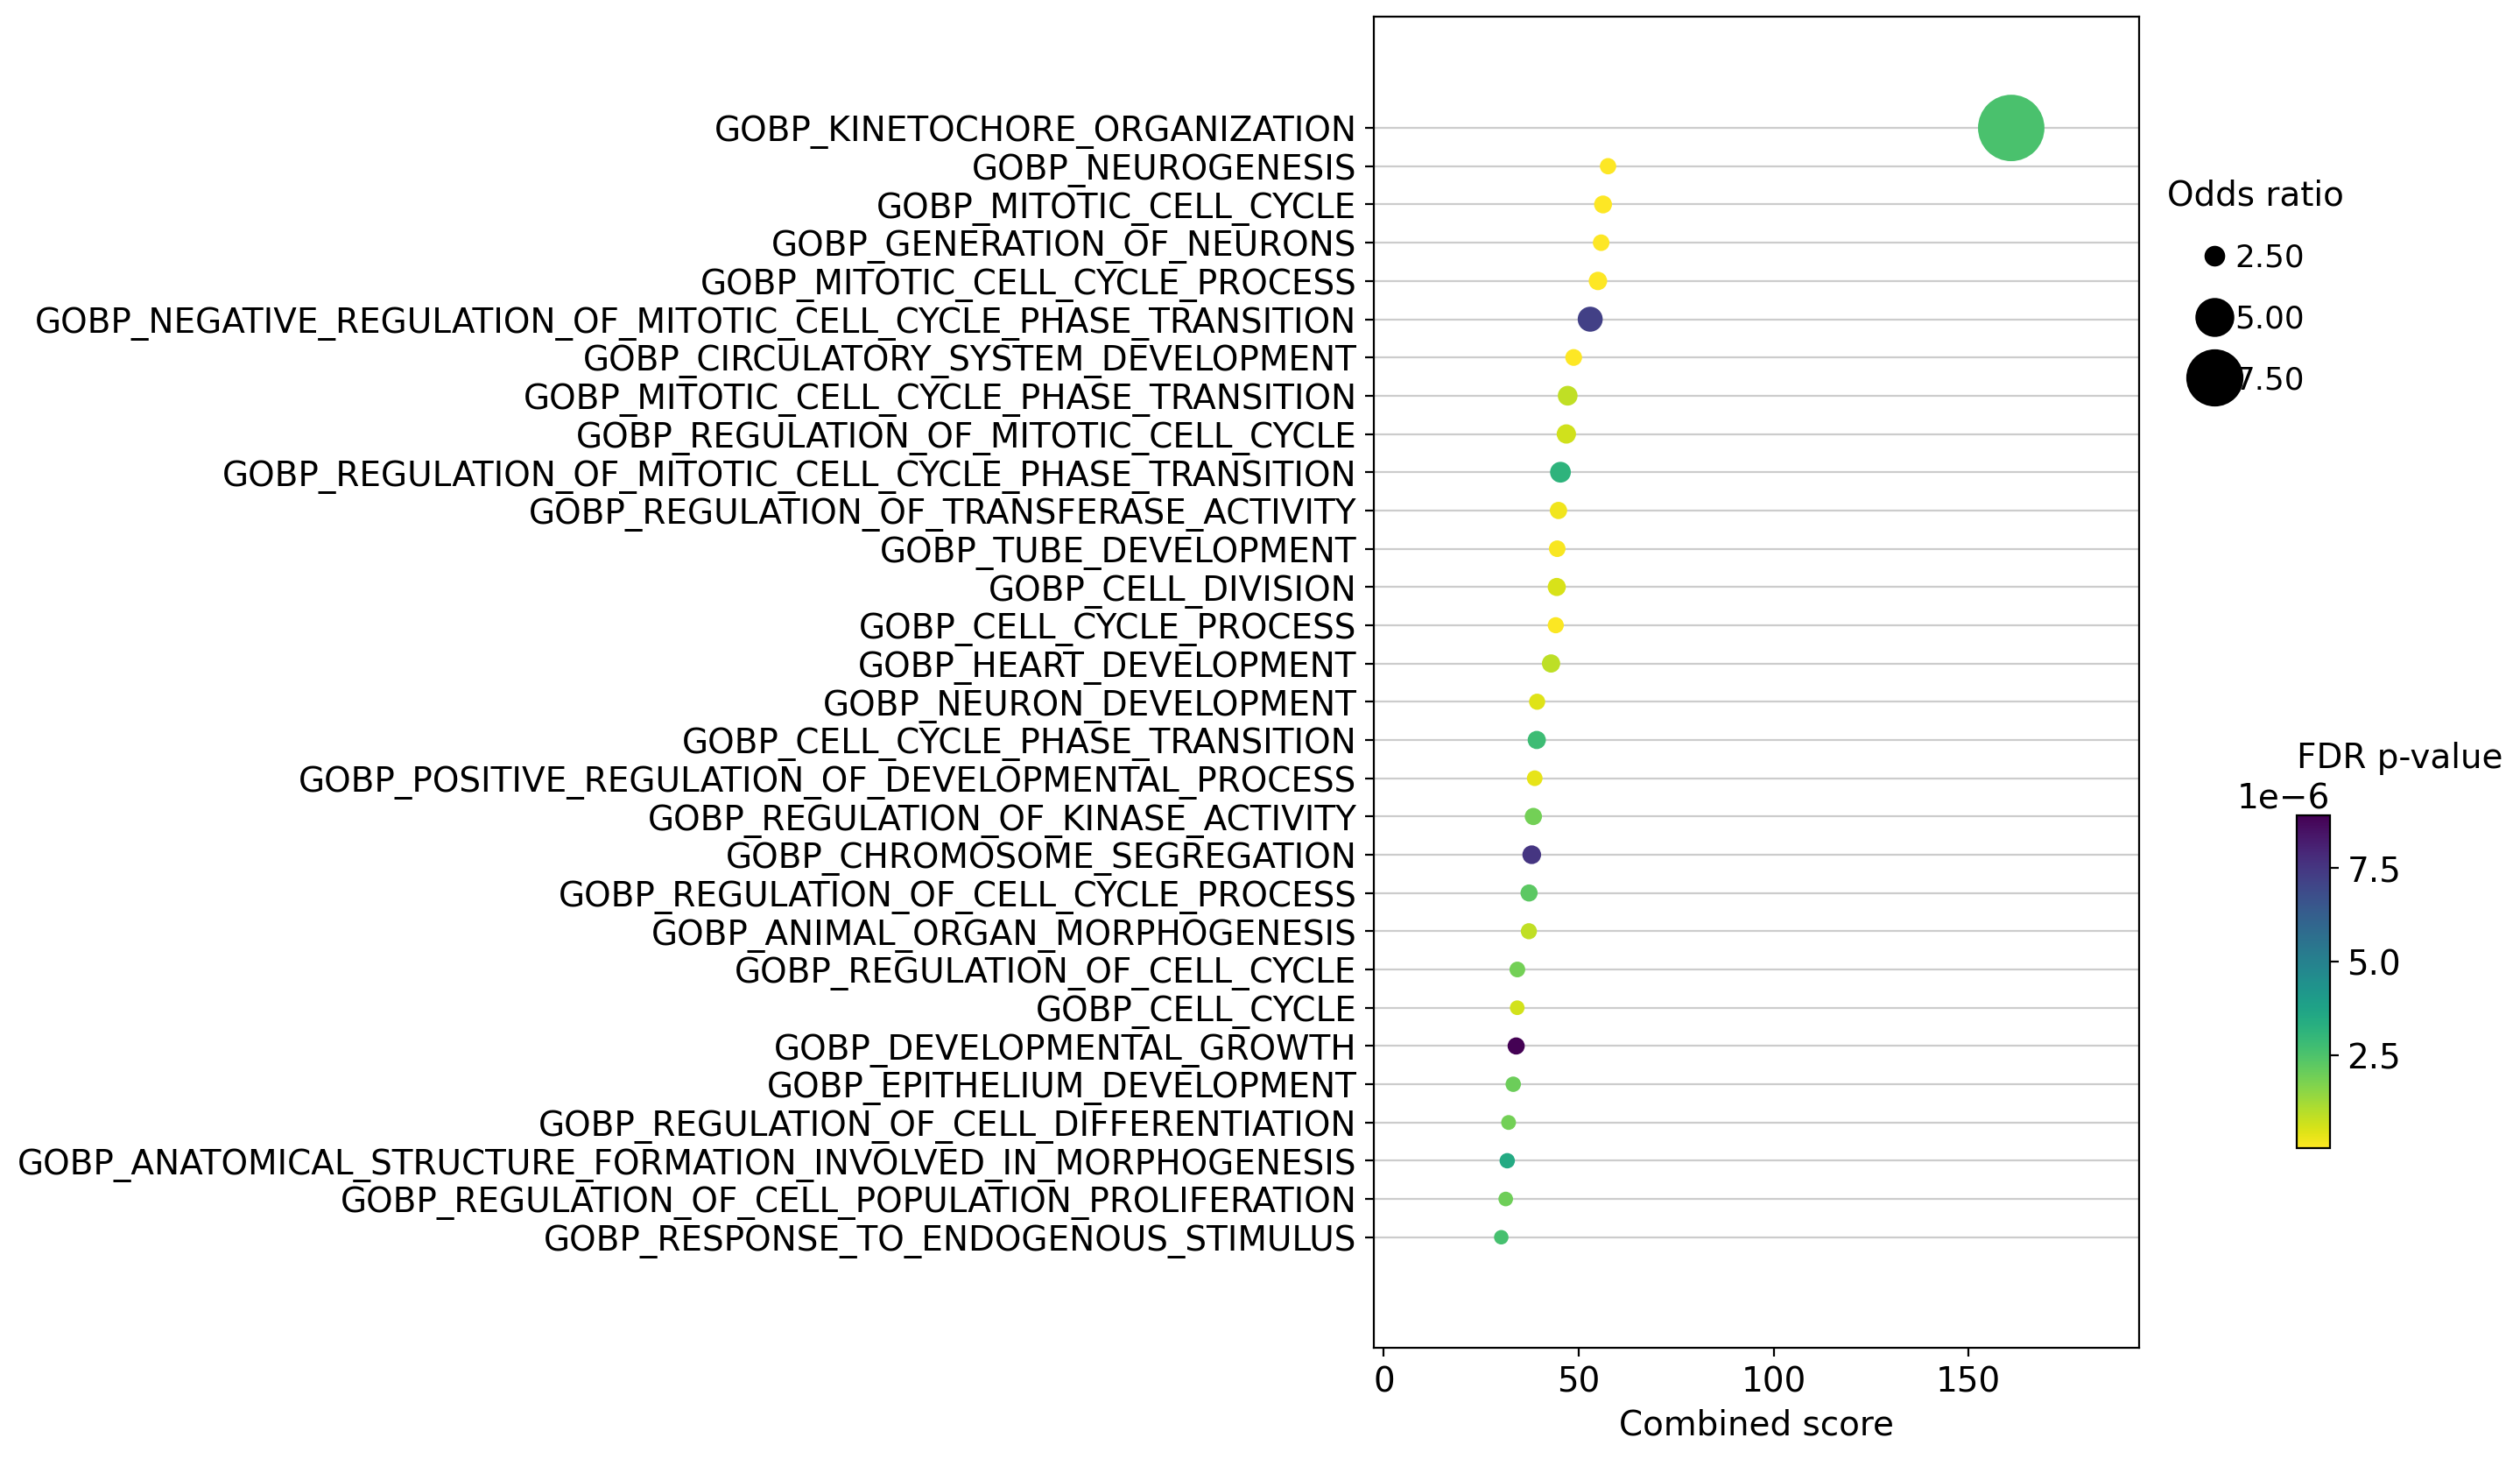

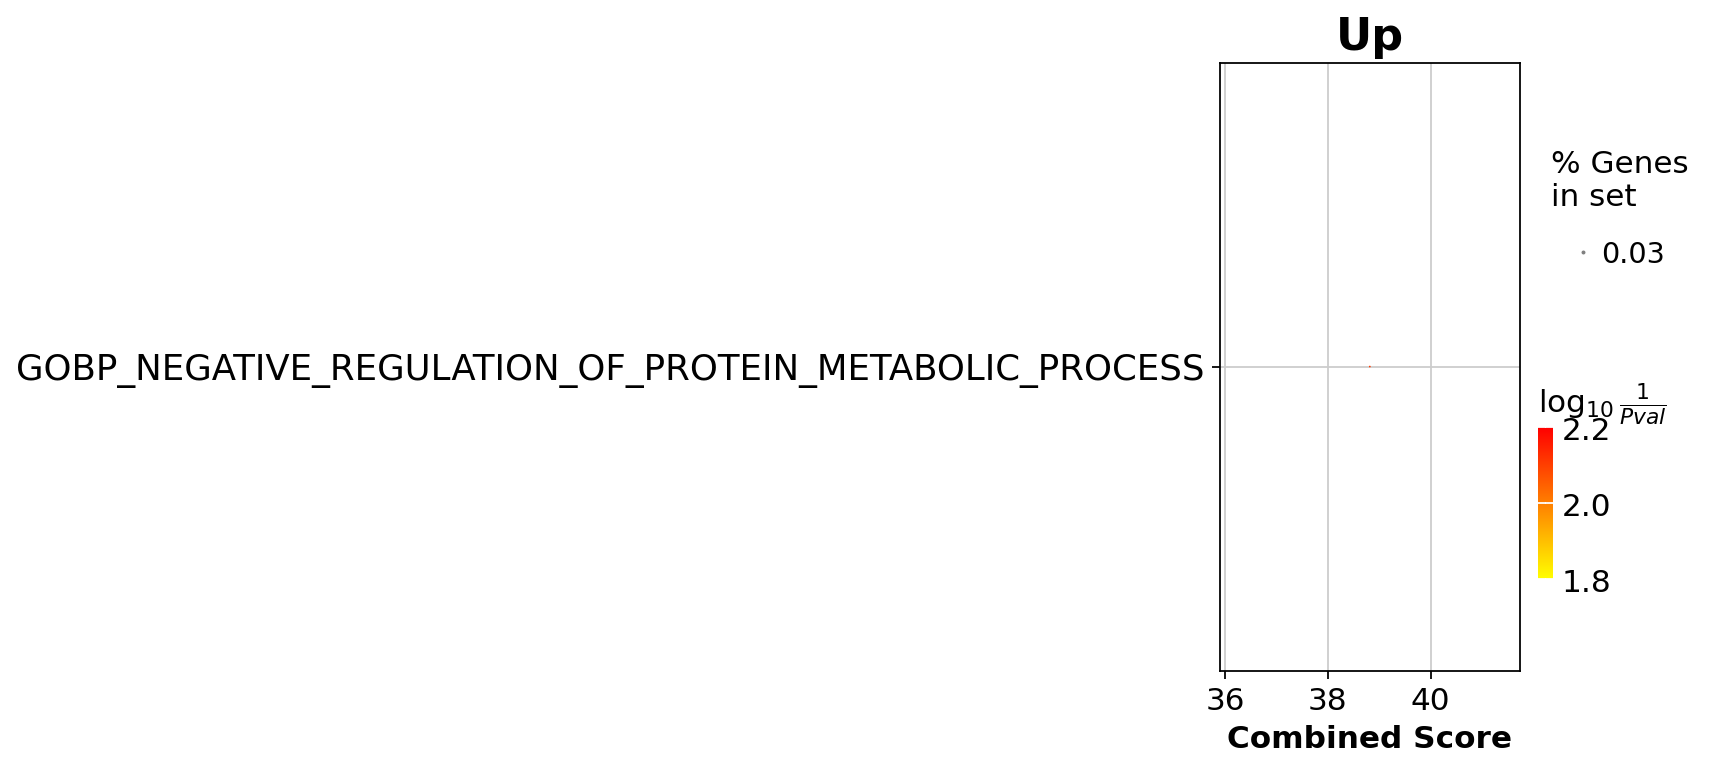

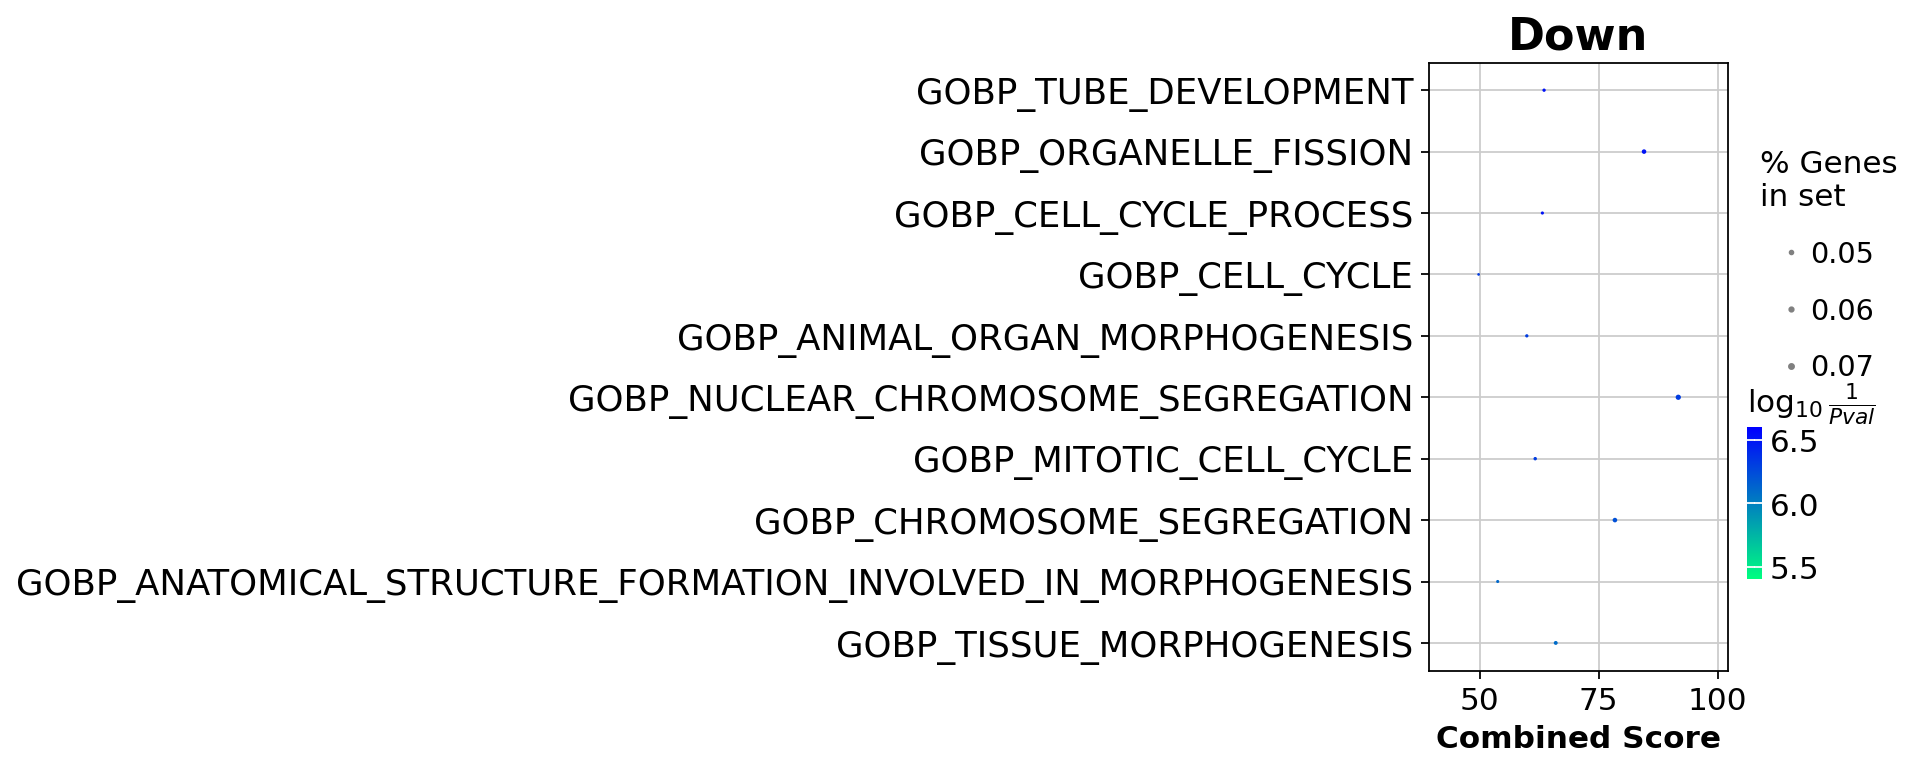

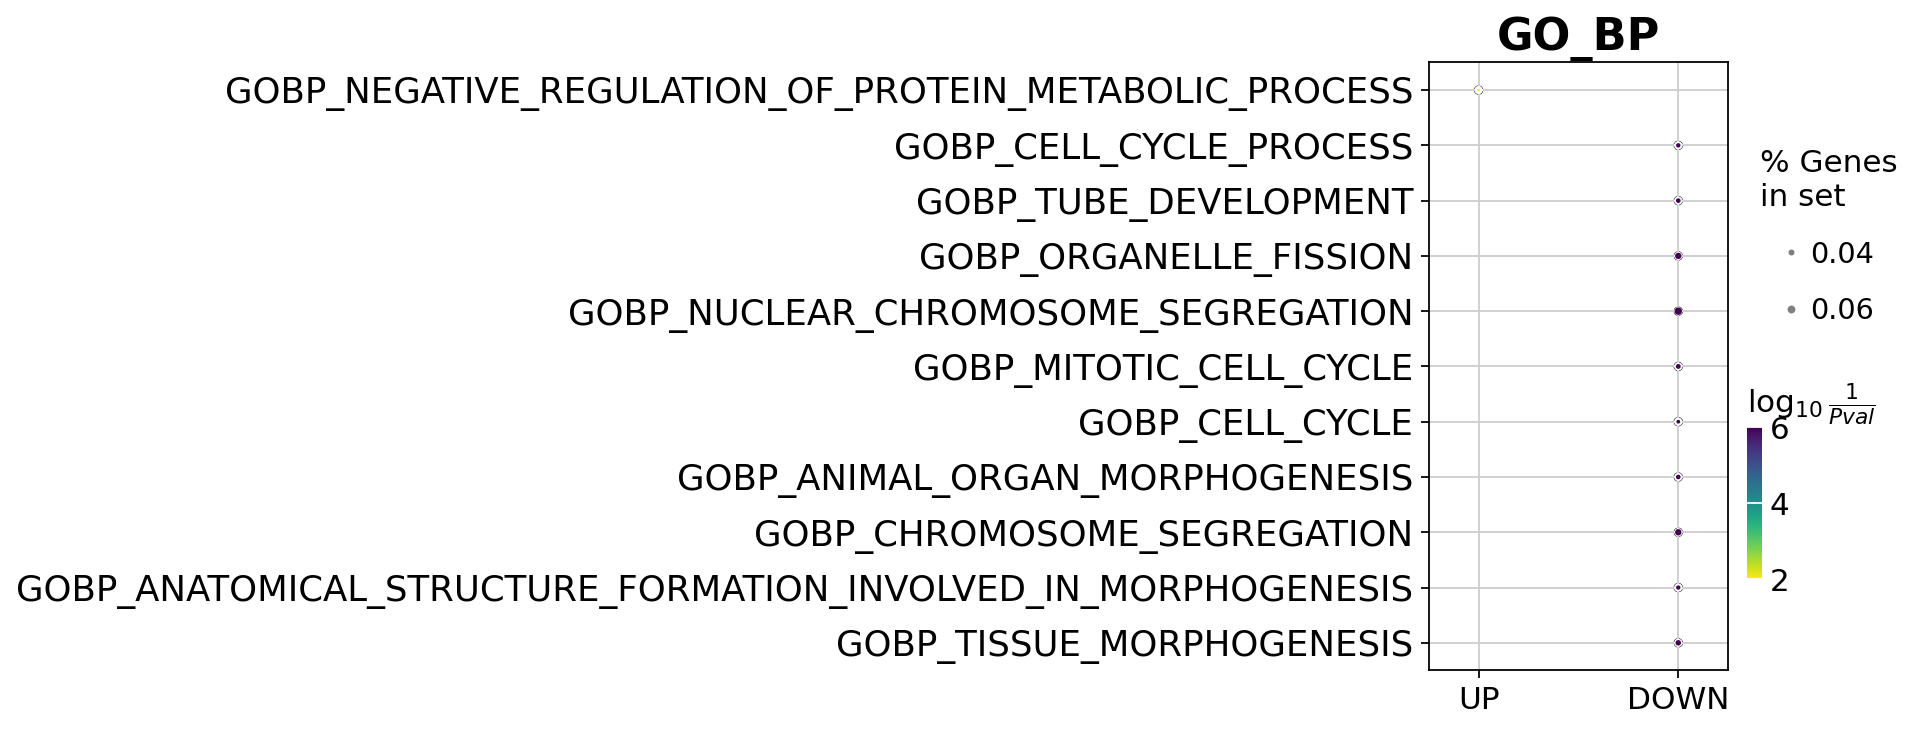

5
Launched ULM for TF slope t-stat
Launched ORA


<Figure size 320x320 with 0 Axes>

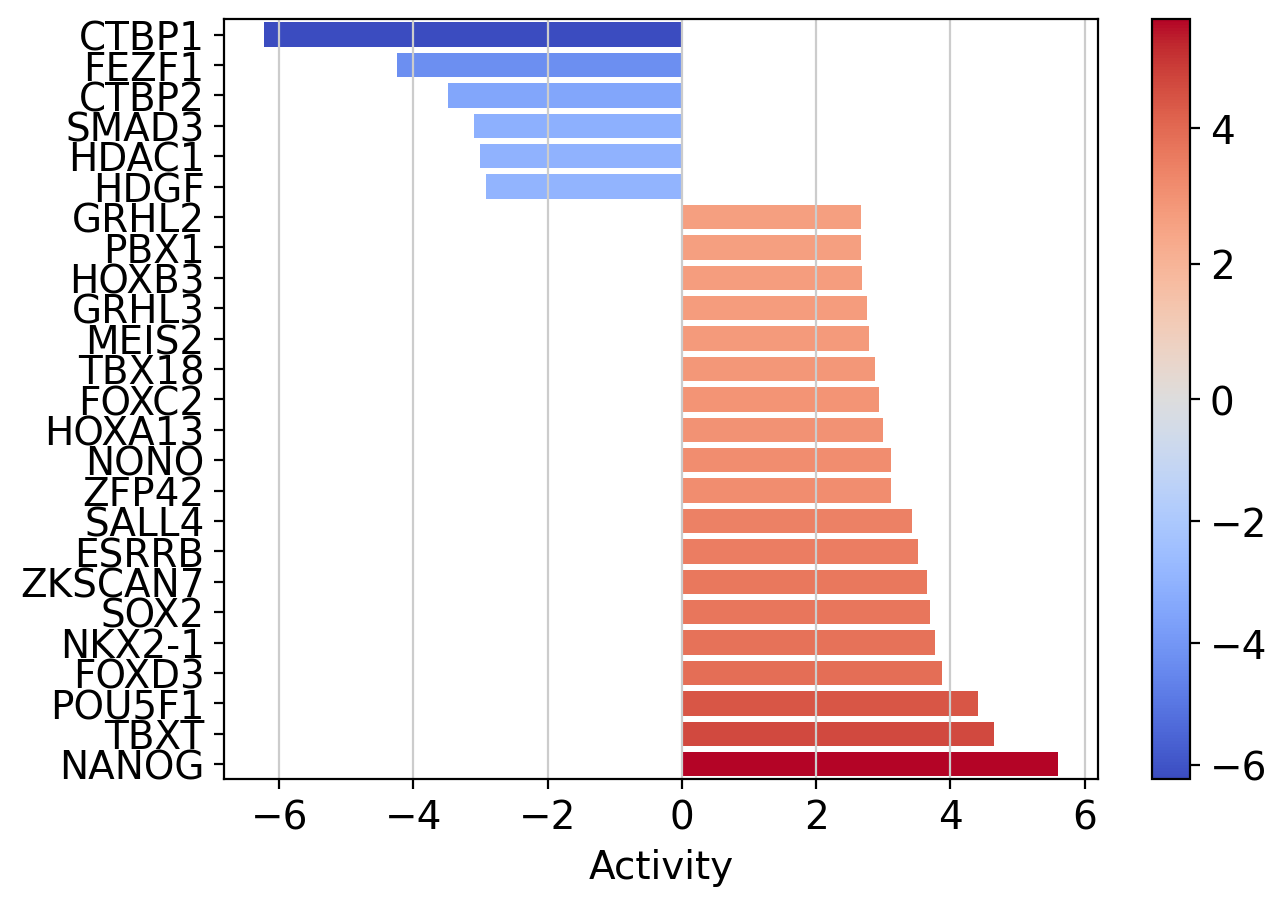

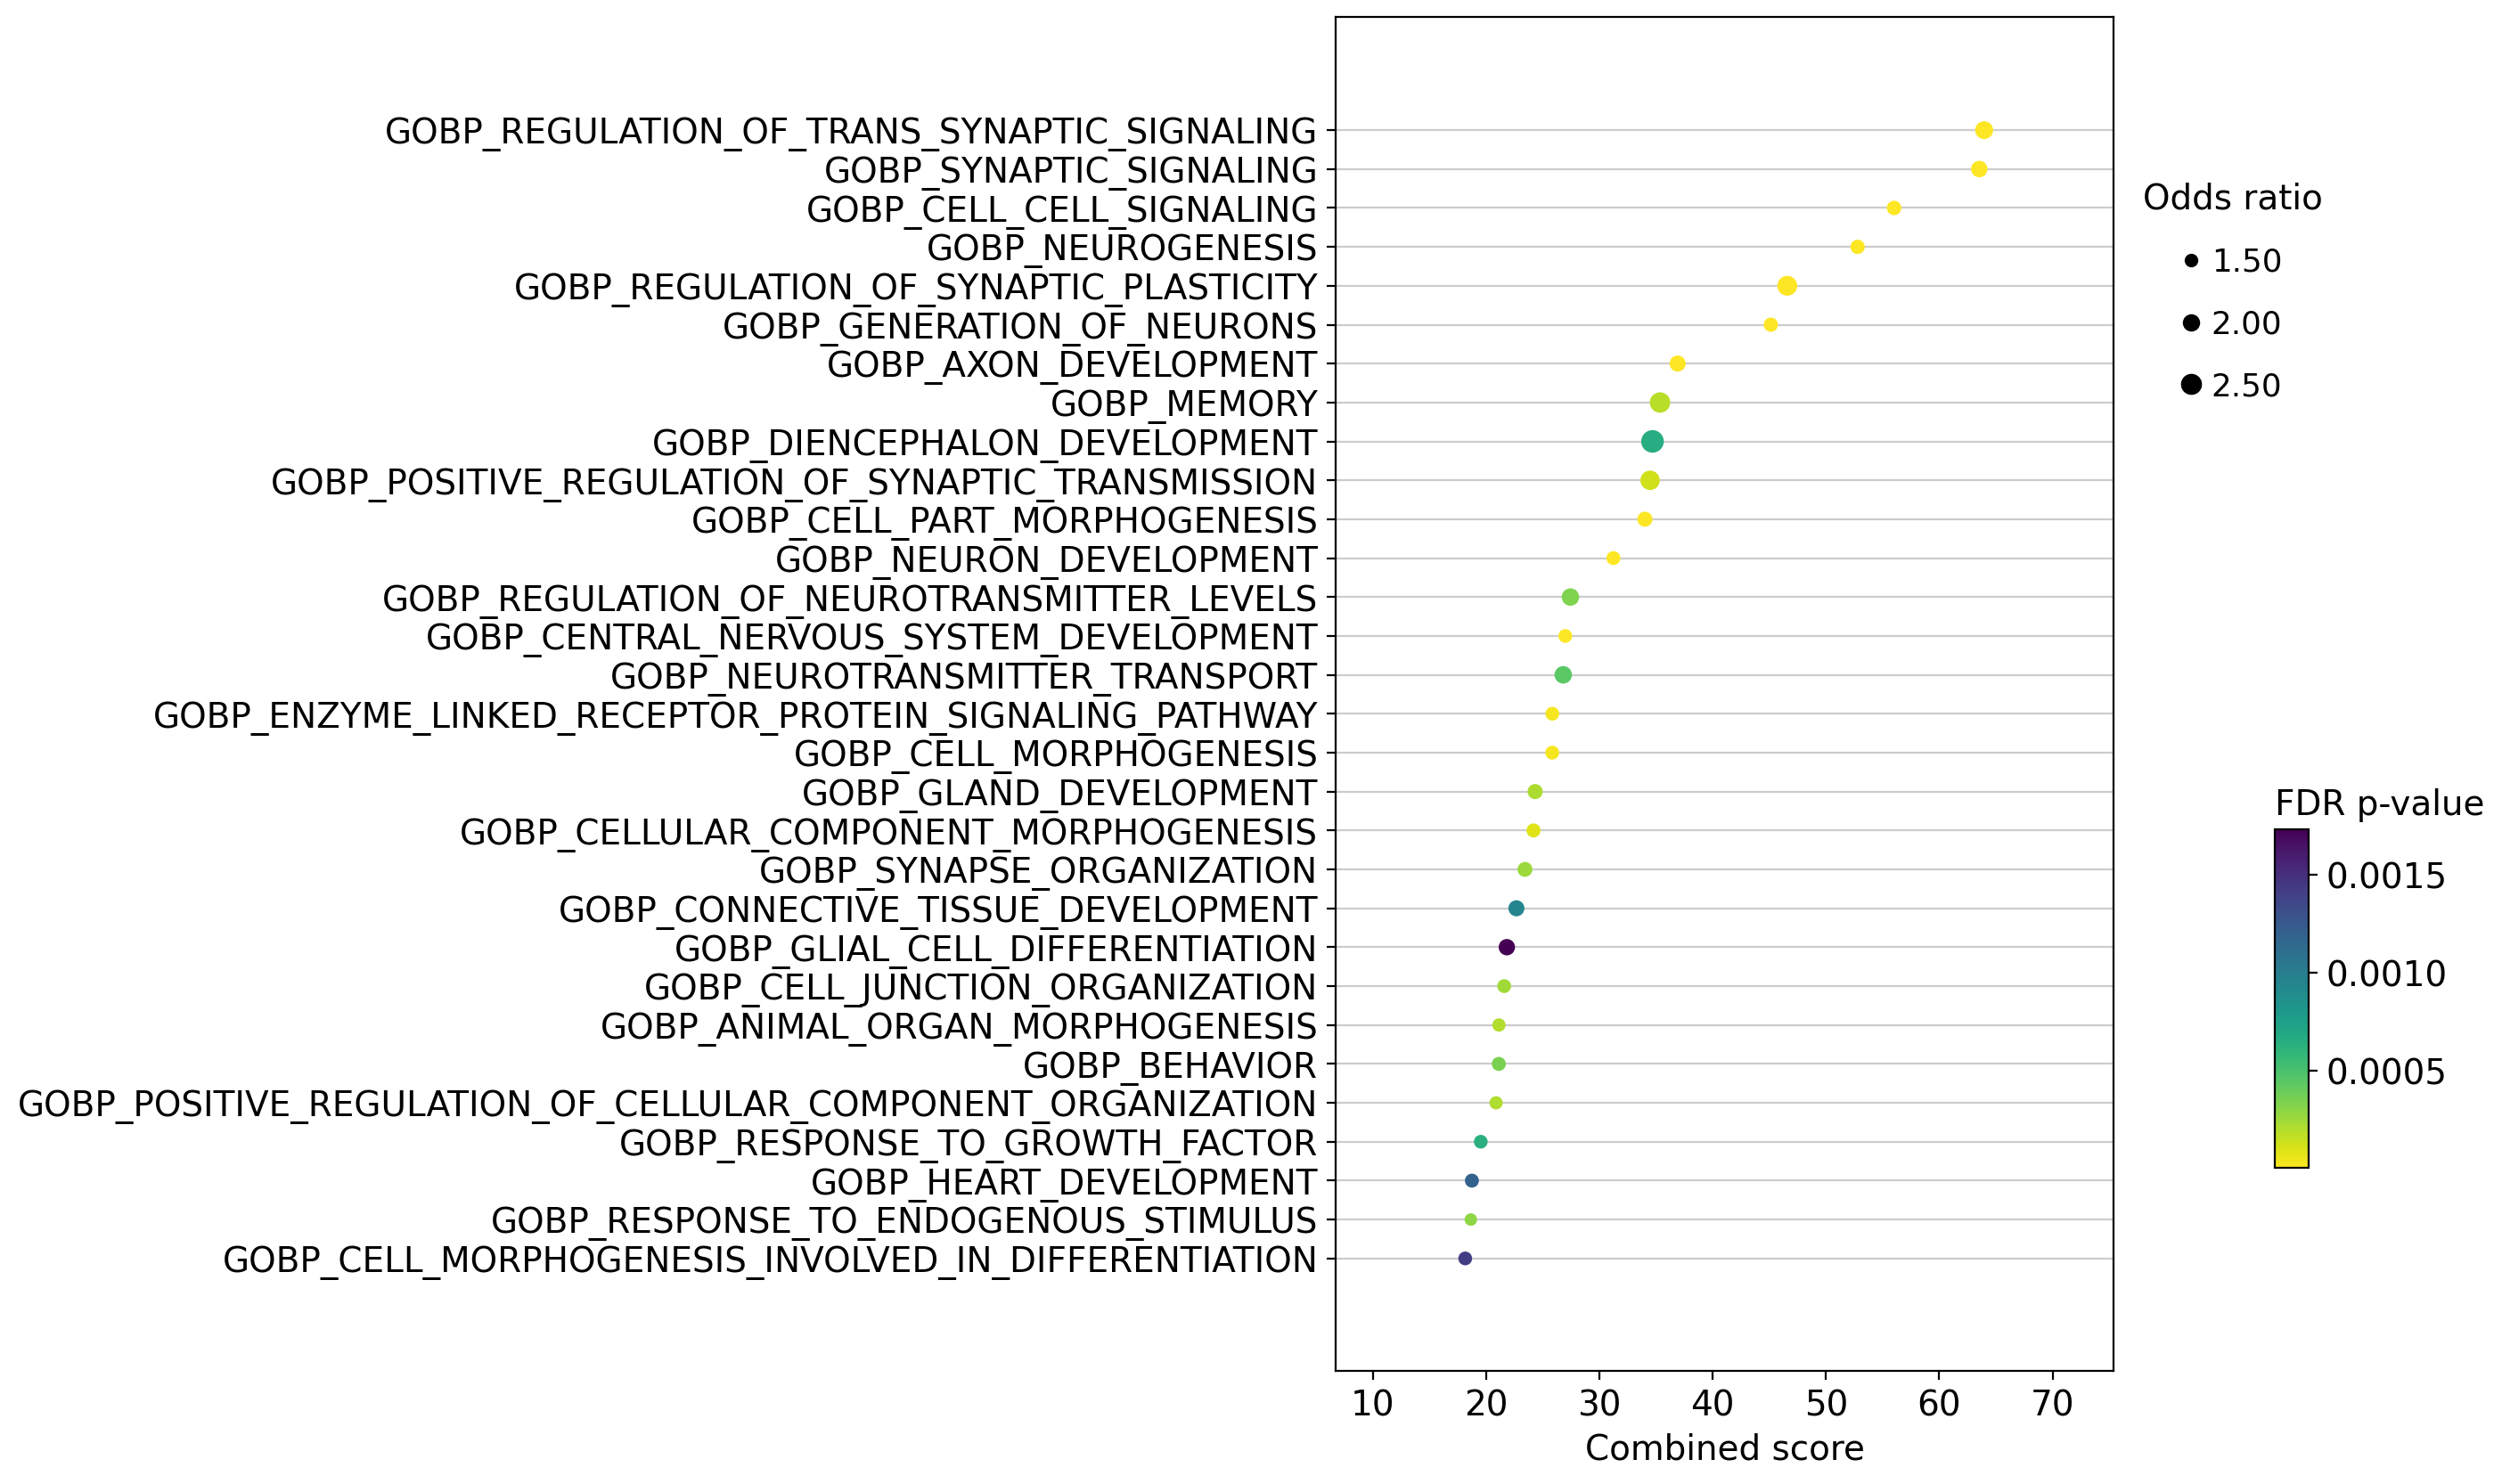

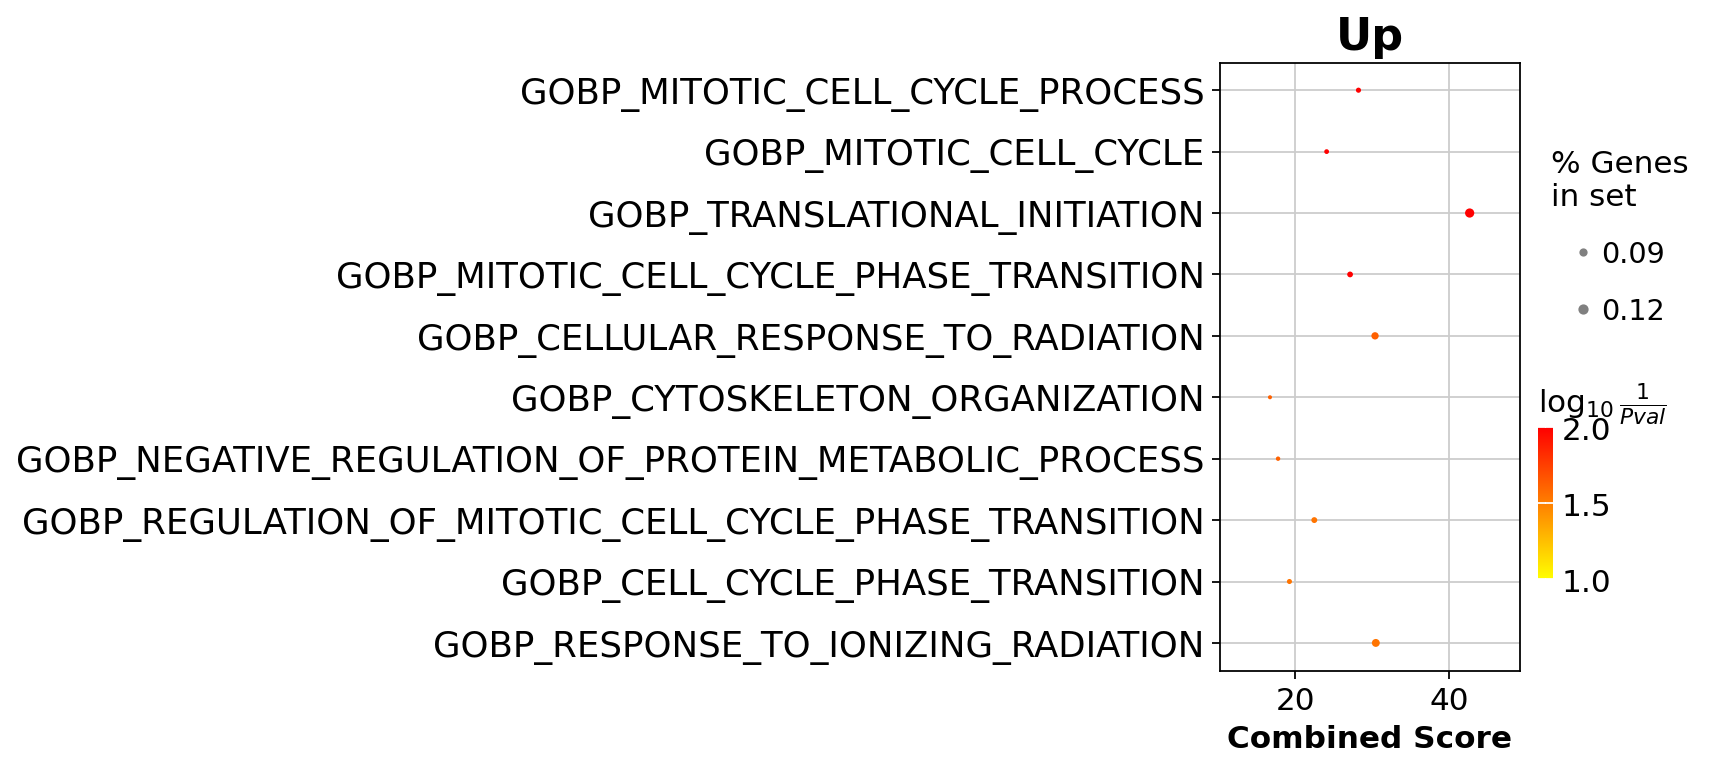

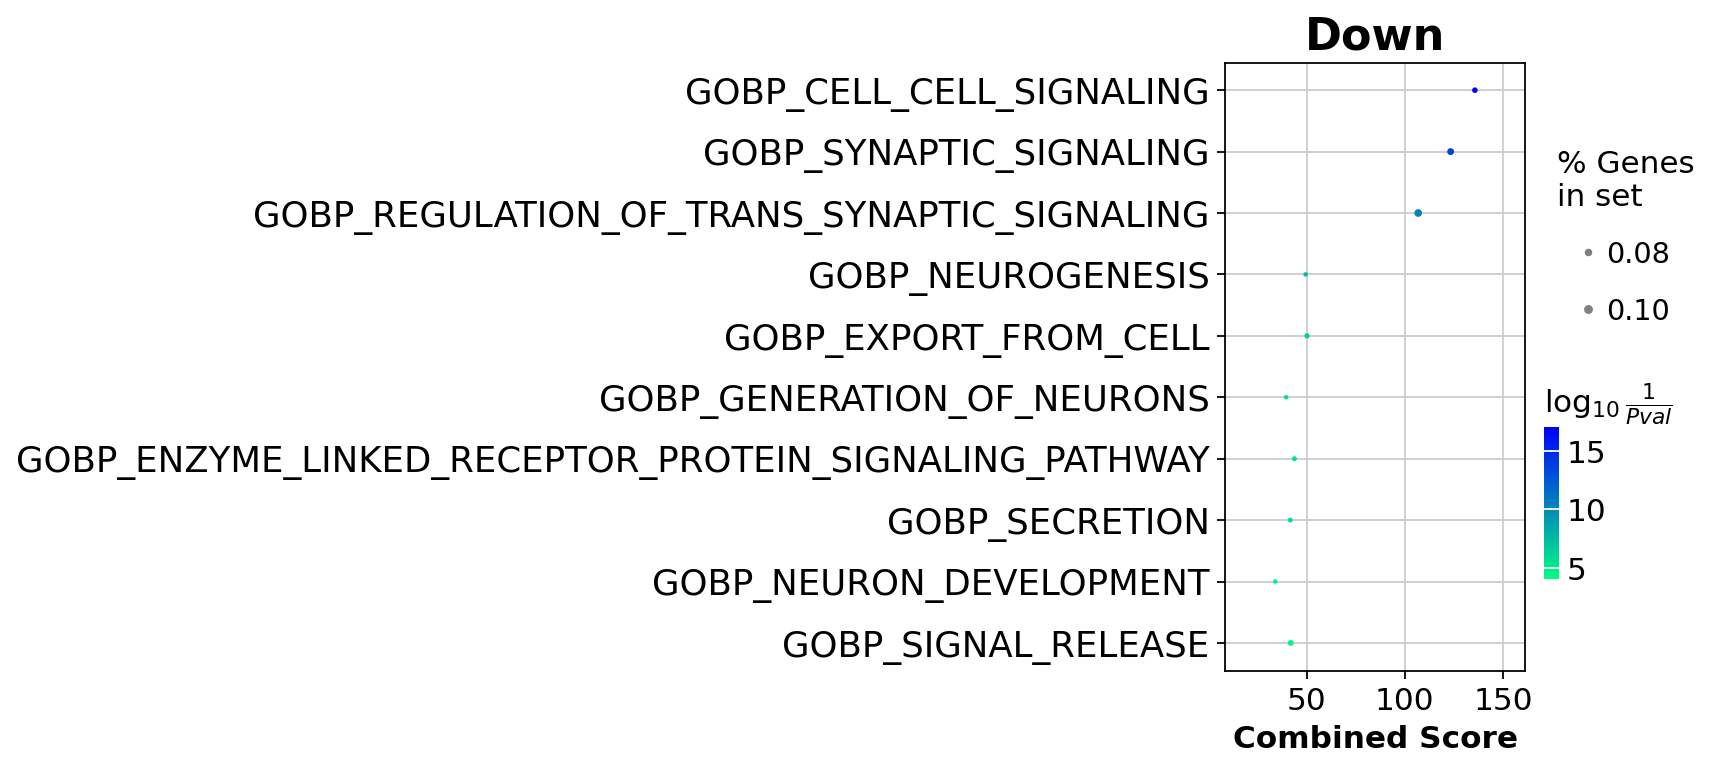

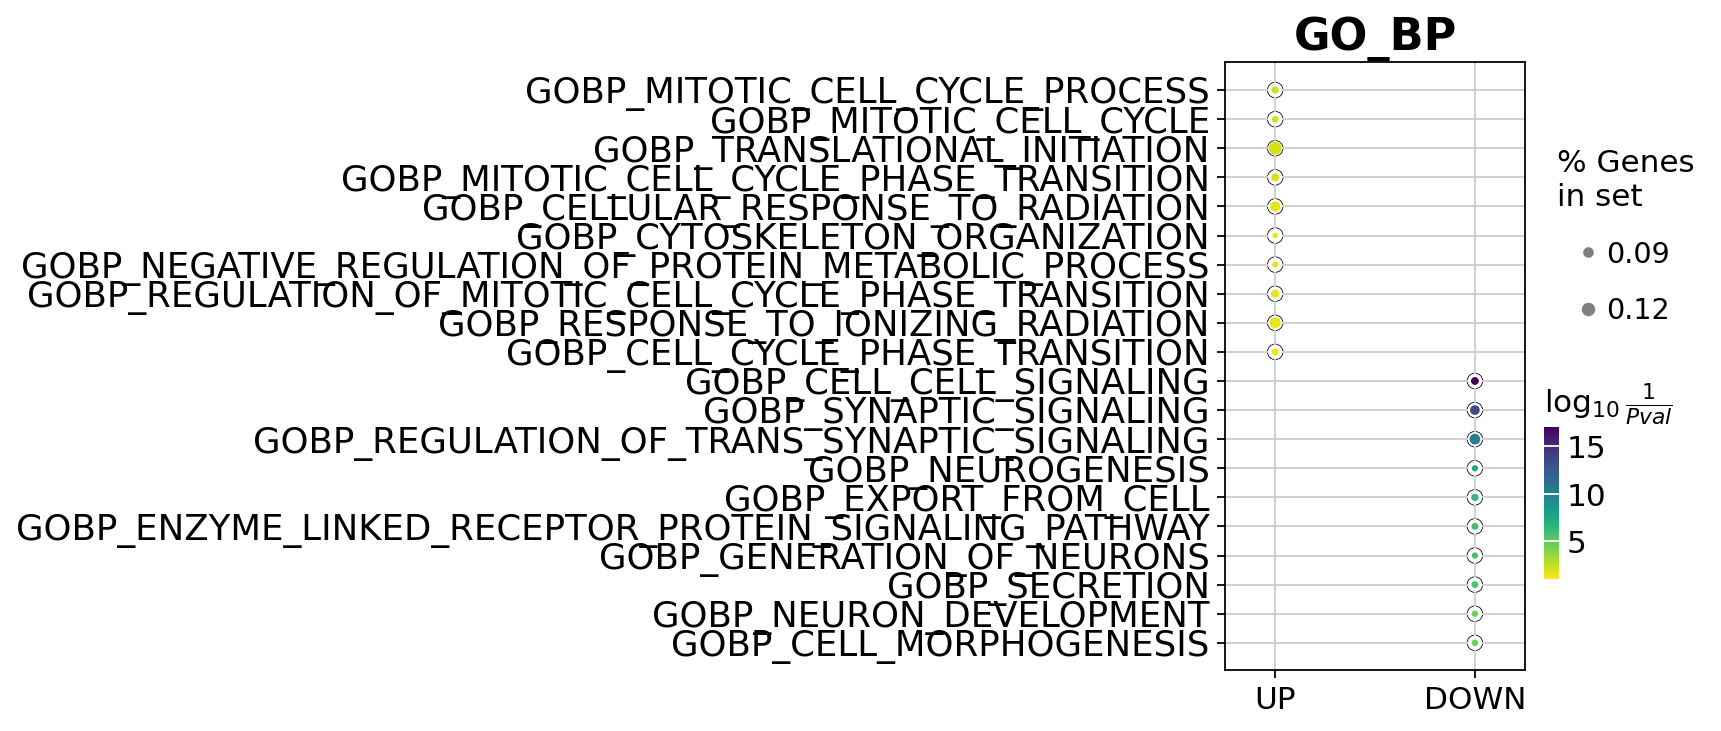

<Figure size 320x320 with 0 Axes>

In [11]:
results = defaultdict(dict)
for week, selected in timeline.items():
    print(week)
    selected['pid'] = week
    # results[week]['gsea_results'] = fu.run_GSEA(selected, reactome)
    
    results[week]['ulm'] = fu.run_ULM(selected, collectri)
    results[week]['ora_results'] = fu.run_ORA(selected, reactome)
    results[week]['ud_ora_results'] = fu.up_down_ORA(selected, sets)

In [15]:
for viss in [ 'ora', 'ulm', 'up_down_ora' ]:
    path = str(config.PATHS.LOGS/'appendix'/(viss + '{}.png'))

    imgs = list()
    for week, selected in timeline.items():
        imgs.append(cv2.imread(path.format(week), cv2.IMREAD_UNCHANGED))
    cv2.imwrite(path.format('combined'), np.concatenate(imgs, axis=1))
    us.log_image(os.path.basename(path.format('combined')))

# Timecourse Analisys

In [17]:
lfc_combined = pd.DataFrame({ 
    k: v.logfoldchanges for k, v in timeline.items() })
p_combined = pd.DataFrame({ 
    k: v.pvals_adj for k, v in timeline.items() })
roi = p_combined.min(1) < config.PROTO.GLM.DEG_THRESHOLD.FDR
roi &= np.abs(lfc_combined).max(1) > config.PROTO.GLM.DEG_THRESHOLD.LFC
p_combined = p_combined[roi]
lfc_combined = lfc_combined[roi]

odds = dict()
for k, v in timeline.items():
    keys = sorted(lfc_combined.columns)
    idx = keys.index(k)

    neighbours = [ 
        keys[el] for el in [idx - 1, idx + 1] if el in range(len(keys))]

    tmp = lfc_combined[neighbours].values - lfc_combined[[k]].values

    if tmp.shape[-1] == 2:
        tmp = tmp.flatten()[
            np.arange(0, 2 * len(tmp), 2)
            + np.argmax(np.abs(tmp), axis=1)][..., np.newaxis]
    odds[k] = tmp.flatten()

In [18]:
odds = pd.DataFrame(odds, index=lfc_combined.index)
odds.sort_values(2).head(20)

1         2          4          5
names                                                 
OPRK1         8.246606 -8.246606  -2.171500   0.303391
NDNF          7.558217 -7.558217   3.990003  -3.361546
AJAP1         7.546282 -7.546282   6.267974  -6.267974
ZIC5          4.447142 -7.518539   7.518539  -4.575070
TGFB3         0.158460 -7.417405   7.417405  -2.315900
ITGA5         2.291338 -7.374230   7.374230  -5.106576
FABP7         3.072648 -7.270495   7.270495  -1.885032
HES5          2.447056 -7.186835   7.186835  -4.609968
RBM47         0.427252 -7.165657  12.057122 -12.057122
SCRG1         4.928601 -7.073179   7.073179  -1.002935
PALMD        -4.022015 -7.036393   7.036393  -4.864102
CLEC4G        6.957481 -6.957481  -5.445212   5.445212
LINC01021     6.853795 -6.853795   1.470486   1.370399
DNAH2         6.836879 -6.836879   1.492493  -0.221803
ZIC2          1.970573 -6.811619   6.811619  -3.790003
RP11-390F4.6  3.740179 -6.810086   6.810086  -1.811395
ITPR1         6.797636 -6.797636  -1.937362   1.937362
RP11-356I2.4  2.252813 -6.737340   6.737340  -4.858450
PCDHA5        6.548169 -6.548169   1.094325   0.596090
CYP26A1      -4.453532 -6.508726   7.634839  -7.634839

In [19]:
odds = pd.DataFrame(odds, index=lfc_combined.index)
odds.sort_values(2).tail(20)

1          2          4         5
names                                                 
HMGCLL1       0.064149   7.070964  -7.525452  7.525452
BMP3         -1.059307   7.139152  -7.139152  5.500439
C20orf195    -0.536795   7.329277  -7.329277  4.596471
WFDC1         0.038956   7.351514  -7.351514  3.870638
RP11-19O2.2  -7.440318   7.440318   1.938055 -1.938055
PHF11        -3.805966   7.466994  -7.466994  2.999730
ZIC1         -7.527362   7.527362   3.763500 -3.655592
GRP          -3.370011   7.647789  -7.647789  4.029487
HOXB8        -6.647522   7.825875  -7.825875  5.891606
SCN7A         1.067686   7.987293  -7.987293  5.482332
LANCL3       -1.177453   8.125297  -8.125297  6.998184
HTR3A        -8.228445   8.228445  -5.552043  5.552043
ST6GALNAC2   -2.078009   8.292021  -8.292021  7.272838
NCAM2        -5.959546   8.496554  -8.496554  6.048751
TTC39A        0.003671   8.713200  -8.713200  6.818069
HOXB5        -8.808388   8.808388  -2.479273  1.943585
SPHKAP       -1.145500   8.826124  -8.826124  4.906622
FAM162B      -2.455522   9.808861  -9.808861  9.201803
ELAVL2      -10.276588  10.276588  -4.112400  2.467117
HOXA3        -4.894321  10.808528 -10.808528  6.890814

In [20]:
p_combined = pd.DataFrame({ 
    k: v['ulm'][1].values[0] 
    for k, v in results.items() if 'ulm' in v },
index=results[1]['ulm'][1].columns)

roi = p_combined.min(1) < config.PROTO.GLM.DEG_THRESHOLD.FDR

p_combined = p_combined[roi]

odds = dict()
for k, v in timeline.items():
    keys = sorted(p_combined.columns)
    idx = keys.index(k)

    neighbours = [ 
        keys[el] for el in [idx - 1, idx + 1] if el in range(len(keys))]

    tmp = np.log(
        p_combined[neighbours].values / p_combined[[k]].values)

    
    if tmp.shape[-1] == 2:
        tmp = tmp.flatten()[
            np.arange(0, 2 * len(tmp), 2)
            + np.argmax(np.abs(tmp), axis=1)][..., np.newaxis]
    odds[k] = tmp.flatten()

In [21]:
odds = pd.DataFrame(odds, index=p_combined.index)
odds.sort_values(2).head(20)

1          2          4          5
E2F1    0.614691 -27.457542  29.381507 -29.381507
E2F3   -0.939315 -14.516236  14.516236 -13.665344
E2F4   -0.361388 -14.372341  14.697114 -14.697114
TCF7L1  3.440599  -9.630860   9.630860  -7.641750
DLX1    9.274022  -9.274022   0.792939  -0.566520
LHX2   -0.336531  -8.710851   9.020297  -9.020297
SP1     1.982427  -8.257104  10.895259 -10.895259
SMAD6   1.843530  -7.809490   9.815382  -9.815382
FOXJ1   0.748231  -7.641640   7.641640  -5.597400
OLIG2   1.574937  -6.361959   6.361959  -5.526125
TBX1    5.992841  -5.992841   1.343208   0.792442
NFKB    2.637544  -5.805454   6.311650  -6.311650
SMAD3   1.619852  -5.677372   5.677372  -3.132032
KLF5    1.669896  -5.660649   6.686290  -6.686290
TEAD1   3.578126  -5.613328   6.133976  -6.133976
MEIS1   0.659810  -5.463004   5.463004  -2.172875
GLI3   -0.404539  -5.427777   5.427777  -5.105677
TCF7L2  2.768384  -5.363127   6.025854  -6.025854
E2F2   -0.570171  -5.346651   5.346651  -3.682532
JUND    5.322223  -5.322223   0.520383  -0.217776

In [22]:
odds = pd.DataFrame(odds, index=p_combined.index)
odds.sort_values(2).tail(20)

1         2          4          5
TBX18   -0.309669  0.381767  -5.011004   5.011004
ZKSCAN7 -0.425556  0.425556  -6.903493   6.903493
HDAC1    0.186388  0.440063  -5.437137   5.437137
FOXD3   -0.499065  0.499065  -8.561375   8.561375
HDGF    -0.547915  0.578246  -4.274956   4.274956
ATF1    -0.388335  0.725996  -1.940995   1.940995
TBXT    -0.236215  0.770738 -12.243346  12.243346
CTBP2    0.203013  1.082613  -5.415724   5.415724
HOXA13  -1.093836  1.645654  -5.403459   5.403459
PTF1A    0.816093  1.696642  -1.696642  -0.255622
CTBP1    1.444103  1.788981 -21.104444  21.104444
STAT1   -2.055885  2.055885   7.956438  -7.956438
ZBTB7B  -2.370219  2.370219   2.501775  -2.501775
SALL4   -3.032486  3.374243  -7.293816   7.293816
HLF     -2.517497  3.784116  -3.784116  -0.808473
FEZF1   -3.965513  3.965513  -9.792722   9.792722
NR2E3   -4.204638  4.204638   8.764387  -8.764387
SCX     -4.596734  4.596734  -3.319727  -2.187159
NFYA    -4.780293  4.780293  -2.971071   0.383837
PRDM4   -5.061870  5.061870  -2.720918  -2.386610

In [ ]:

    Define gene sets of interest (e.g from KEGG pathways, Molecular Signature Database, GO, etc...) Polycomb gene regulatory network is a first candidate from Studer study
    We can then apply several strategies:
        Plot levels across cells / pseudobulk samples
        Calculate gene scores ()
        Use them as gene sets for GSEA-like approaches
